# Machine Learning - Overview

The purpose of this notebook is to implement and compare machine learning models for predicting daily solar energy availability using weather forecast variables. 3 different model types have been built and compared. 

## Machine Learning Models Built:
- Ordinary Least Squares
- Stochastic Gradient Descent (SGD)
- Gradient Boosting Regressor

The goal of these models is to predict the total daily energy availability (W/m^2) at each of the 98 Mesonet Stations using the weather forecast variables for each location and day. 

# Data Importing and Organization

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns

import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy.stats import pearsonr

from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor


import pickle

In [2]:
df = pd.read_csv('ML_dataset_filtered.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').drop(['stid', 'year', 'day'], axis=1)

In [3]:
df.head()

energy      nlat       elon  elev  apcp_sfc_fhour0  \
Date                                                               
1994-01-01  12384900  34.80833  261.97675   397              0.0   
1994-01-02  11908500  34.80833  261.97675   397              0.0   
1994-01-03  12470700  34.80833  261.97675   397              0.0   
1994-01-04  12725400  34.80833  261.97675   397              0.0   
1994-01-05  10894800  34.80833  261.97675   397              0.0   

            apcp_sfc_fhour1  apcp_sfc_fhour2  apcp_sfc_fhour3  \
Date                                                            
1994-01-01              0.0              0.0             0.00   
1994-01-02              0.0              0.0             0.01   
1994-01-03              0.0              0.0             0.00   
1994-01-04              0.0              0.0             0.00   
1994-01-05              0.0              0.0             0.00   

            apcp_sfc_fhour4  dlwrf_sfcfhour0  ...  ulwrf_tatfhour1  \
Date                                          ...                    
1994-01-01              0.0        256.01898  ...        250.69777   
1994-01-02              0.1        258.01898  ...        232.06482   
1994-01-03              0.0        219.61050  ...        232.01129   
1994-01-04              0.0        266.24475  ...        243.53894   
1994-01-05              0.0        238.19739  ...        235.32010   

            ulwrf_tatfhour2  ulwrf_tatfhour3  ulwrf_tatfhour4  \
Date                                                            
1994-01-01        253.00000        263.59940        260.80518   
1994-01-02        232.53503        231.00787        232.05087   
1994-01-03        235.49771        252.00594        247.46686   
1994-01-04        245.44907        254.23553        250.00110   
1994-01-05        242.18672        258.26974        241.10945   

            uswrf_sfcfhour0  uswrf_sfcfhour1  uswrf_sfcfhour2  \
Date                                                            
1994-01-01              0.0              9.0             49.0   
1994-01-02              0.0              8.0             35.0   
1994-01-03              0.0              9.0             50.0   
1994-01-04              0.0              9.0             50.0   
1994-01-05              0.0              8.0             48.0   

            uswrf_sfcfhour3  uswrf_sfcfhour4  month  
Date                                                 
1994-01-01            107.0             74.0      1  
1994-01-02             73.0             49.0      1  
1994-01-03            111.0             75.0      1  
1994-01-04            112.0             77.0      1  
1994-01-05            107.0             71.0      1  

[5 rows x 80 columns]

# Time Series Cross Validation

The time series energy data displays auto-correlation on a year-to-year scale. We will therefore use temporally contiguous blocks for cross-validation, forcing testing on more temporally distant records, reducing temporal dependence and reducing optimism in error estimates. We are attempting to ensure independence between cross-validation folds. 

Source: https://onlinelibrary.wiley.com/doi/full/10.1111/ecog.02881


The data have been split into the following groups (years are inclusive):

- 1994-1995: Contiguous Fold 1
- 1996-1997: Contiguous Fold 2
- 1998-1999: Contiguous Fold 3
- 2000-2001: Contiguous Fold 4
- 2002-2003: Contiguous Fold 5
- 2004-2007: Test Data

Contiguous Folds 1-5 together makeup the train dataset.

The cross-validation strategy is as follows:
- Choose 1 contiguous fold as test data and use remaining contiguous folds as training data
    - Calculate CV score - Mean Absolute Error
- Perform the above process 5 times, with each of the contiguous folds being the test data
    - Calculate average CV score
- Finally, use all 5 contiguous folds as training data and calculate the test data score

The models will be evaluated based on the following:
- Average CV score (across 5 folds)
- Test data score

In [4]:
def cv_score(reg, X_train, y_train, score_func=mean_absolute_error):
    """
    Returns a DataFrame of the 5 CV scores and an average CV score using 5 contiguous folds. 
    If regressor is desired to be 'OLS', input 'ols' as a string for the reg input, otherwise, input a regressor object.
    CV score is the Mean Absolute Error.
    """
    # In here for now to surpress a warning
    pd.options.mode.chained_assignment = None
    
    # Initilize cv result
    result = 0

    # Split data into 5 contiguous folds
    years = list(range(1994, 2004))
    n_fold = 5
    fold = 0
    
    # Initialize cv scores dataframe
    cv_scores = pd.DataFrame()
    
    # For every 2 years in the list of years, set train and test data and perform model fitting/predicting
    # Store the cv score results and average cv score for returning
    for i in list(range(0, len(years), 2)):
        
        # Set training data - all years except 2
        X_tr = X_train[(X_train.index.year != years[i]) & (X_train.index.year != years[i+1])]
        y_tr = y_train[(y_train.index.year != years[i]) & (y_train.index.year != years[i+1])].to_frame()
        
        # Set testing data - the 2 years exluded from the training data
        X_te = X_train.loc[str(years[i]):str(years[i+1])].astype(float)
        y_te = y_train.loc[str(years[i]):str(years[i+1])].to_frame().astype(float)
    
        # OLS regression
        if reg == 'ols':
            
            # Add target variable back into the training array
            X_tr['energy'] = y_tr.loc[:, 'energy']
            
            # Construct the OLS string to be used by ols function
            ols_string = 'energy ~ ' + ''.join([i + ' + ' for i in X_tr.columns[:-1]])[:-3]

            # Fit and predict
            m = ols(ols_string, X_tr).fit()
            mae = score_func(m.predict(X_te), y_te)
            result += mae
            
            # Store results
            temp_df = pd.DataFrame()
            temp_df['fold'] = [fold + 1]
            temp_df['cv_mae'] = [mae]
            cv_scores = cv_scores.append(temp_df)
        
        # Else, non-ols
        else:
            
            # Fit and predict
            reg.fit(X_tr, y_tr)
            mae = score_func(reg.predict(X_te), y_te)
            result += mae
            
            # Store results
            temp_df = pd.DataFrame()
            temp_df['fold'] = [fold + 1]
            temp_df['cv_mae'] = [mae]
            cv_scores = cv_scores.append(temp_df)
            
        fold += 1
        
        average_cv = result / n_fold
        
    return average_cv, cv_scores

# Model 1a: OLS - BASELINE (NO FEATURE SELECTION)

- Linear regression is one the the most commonly used methods to produce predictive models.
- It is relatively easy to implement and interpret.
- Linear regression (with more than two variables) works by fitting a hyperplane to a set of points in n-dimensions (n = number of features)
- Linear regression generally requires the following assumptions:

    1) A linear relationship between the target variables and the features exists:
        - This assumption will be tested by analyzing the regression coefficients and scatterplots of energy vs a feature.
    2) No multicollinearity in the data:
        - This assumption will be tested using a correlation matrix of the features.
    3) Homoscedasticity (constant variance) of residuals:
        - This assumption will be tested visually and using the breusch-pagan test.
    4) Normally distributed residuals: 
        - This assumption will be tested using a histogram plot of the residuals and Q-Q plots.

In [131]:
X_train = df.loc['1994':'2003'].iloc[:, 1:]
y_train = df.energy.loc['1994':'2003']
X_test = df.loc['2004':'2007'].iloc[:, 1:]
y_test = df.energy.loc['2004':'2007']

In [74]:
df_ols = df.copy()
df_ols_train = df_ols.loc['1994':'2003']
df_ols_train

energy      nlat       elon  elev  apcp_sfc_fhour0  \
Date                                                               
1994-01-01  12384900  34.80833  261.97675   397             0.00   
1994-01-02  11908500  34.80833  261.97675   397             0.00   
1994-01-03  12470700  34.80833  261.97675   397             0.00   
1994-01-04  12725400  34.80833  261.97675   397             0.00   
1994-01-05  10894800  34.80833  261.97675   397             0.00   
1994-01-06   6639000  34.80833  261.97675   397             0.00   
1994-01-07  13244700  34.80833  261.97675   397             0.00   
1994-01-08  12927900  34.80833  261.97675   397             0.00   
1994-01-09  12600300  34.80833  261.97675   397             0.00   
1994-01-10   6406500  34.80833  261.97675   397             0.83   
1994-01-11  12743400  34.80833  261.97675   397             0.00   
1994-01-12  10453500  34.80833  261.97675   397             0.00   
1994-01-13  12985200  34.80833  261.97675   397             0.00   
1994-01-14  13080000  34.80833  261.97675   397             0.00   
1994-01-15  11826300  34.80833  261.97675   397             0.00   
1994-01-16   1974000  34.80833  261.97675   397             0.20   
1994-01-17  13541700  34.80833  261.97675   397             0.00   
1994-01-18  13673700  34.80833  261.97675   397             0.00   
1994-01-19   6796800  34.80833  261.97675   397             0.00   
1994-01-20   5658900  34.80833  261.97675   397             0.07   
1994-01-21   7073400  34.80833  261.97675   397             0.00   
1994-01-22   3354000  34.80833  261.97675   397             0.41   
1994-01-23   2579700  34.80833  261.97675   397             0.10   
1994-01-24   2387700  34.80833  261.97675   397             0.08   
1994-01-25   8390700  34.80833  261.97675   397             0.00   
1994-01-26   7326600  34.80833  261.97675   397             1.00   
1994-01-27  10743900  34.80833  261.97675   397             0.00   
1994-01-28  12812100  34.80833  261.97675   397             0.00   
1994-01-29   9065100  34.80833  261.97675   397             0.00   
1994-01-30   3954900  34.80833  261.97675   397             0.00   
...              ...       ...        ...   ...              ...   
2003-12-02   1770300  36.51806  263.65778   269             0.00   
2003-12-03   2823300  36.51806  263.65778   269             4.85   
2003-12-04   7061700  36.51806  263.65778   269             0.00   
2003-12-05   6474300  36.51806  263.65778   269             0.00   
2003-12-06  10083300  36.51806  263.65778   269             0.00   
2003-12-07   9522300  36.51806  263.65778   269             0.00   
2003-12-08   5502300  36.51806  263.65778   269             0.00   
2003-12-09   2122200  36.51806  263.65778   269             1.82   
2003-12-10  11784600  36.51806  263.65778   269             0.38   
2003-12-11  11425800  36.51806  263.65778   269             0.00   
2003-12-12   6472800  36.51806  263.65778   269             0.00   
2003-12-13   5894700  36.51806  263.65778   269             5.10   
2003-12-14   8921400  36.51806  263.65778   269             0.02   
2003-12-15   7999800  36.51806  263.65778   269             0.00   
2003-12-16   8085000  36.51806  263.65778   269             0.00   
2003-12-17  10527000  36.51806  263.65778   269             0.00   
2003-12-18  10975800  36.51806  263.65778   269             0.00   
2003-12-19  11200800  36.51806  263.65778   269             0.00   
2003-12-20  10819500  36.51806  263.65778   269             0.00   
2003-12-21   9349500  36.51806  263.65778   269             0.00   
2003-12-22   1142700  36.51806  263.65778   269             0.00   
2003-12-23  11118300  36.51806  263.65778   269             0.30   
2003-12-24  10816500  36.51806  263.65778   269             0.00   
2003-12-25  10706100  36.51806  263.65778   269             0.00   
2003-12-26   5729700  36.51806  263.65778   269             0.00   
2003-12-27   1282200  36.51806  263.65778   269             1.25   
20

In [7]:
average_cv, cv_scores = cv_score('ols', X_train, y_train, score_func=mean_absolute_error)
print('Average CV MAE: %.0f' % average_cv)
cv_scores.reset_index(drop=True)

Average CV MAE: 2353201


fold        cv_mae
0     1  2.382900e+06
1     2  2.511185e+06
2     3  2.352521e+06
3     4  2.273140e+06
4     5  2.246260e+06

In [8]:
ols_string = 'energy ~ ' + ''.join([i + ' + ' for i in df_ols_train.columns[1:]])[:-3]

m_ols = ols(ols_string,df_ols_train).fit()
print('MAE: %.0f' % mean_absolute_error(m_ols.predict(X_test), y_test))
print(m_ols.summary())

MAE: 2203998
                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                 2.243e+04
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:36:06   Log-Likelihood:            -5.8372e+06
No. Observations:              355413   AIC:                         1.167e+07
Df Residuals:                  355333   BIC:                         1.168e+07
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.129e+08   

In [137]:
model_1a_mae = 2203998
mean_energy = df.energy.mean()

mae_pct = model_1a_mae / mean_energy * 100
mae_pct

13.302769331568143

In [132]:
# Calculate test data Pearson R
model_1a_test_pearson = pearsonr(m_ols.predict(X_test), y_test)
model_1a_test_pearson_adj = 1 - (1 - model_1a_test_pearson[0]) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
model_1a_test_pearson_adj


0.9148125354348459

## 1a OLS - BASELINE Model Evaluation

### Assumption: Linear relationship between target variables and features exists

Analyzing the regression coefficients above, we can see that rises or falls in each of the features are associated with rises or falls in target variable. 

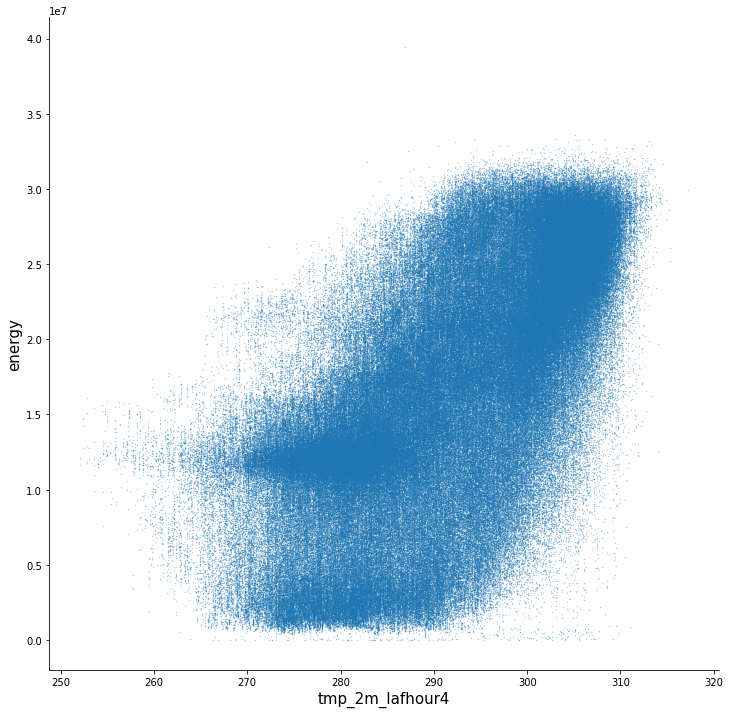

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(df['tmp_2m_lafhour4'], df['energy'], s=0.1, alpha=0.5)
plt.xlabel('tmp_2m_lafhour4', fontsize=15)
plt.ylabel('energy', fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_fitted_vs_actual', bbox_inches='tight')

plt.savefig('tmp_2m_fhour4_energy_scatterplot', bbox_inches='tight')

plt.show()

- Plotting one of the features against energy shows a linear relationship between the two variables.

### Assumption: No multicollinearity in the data

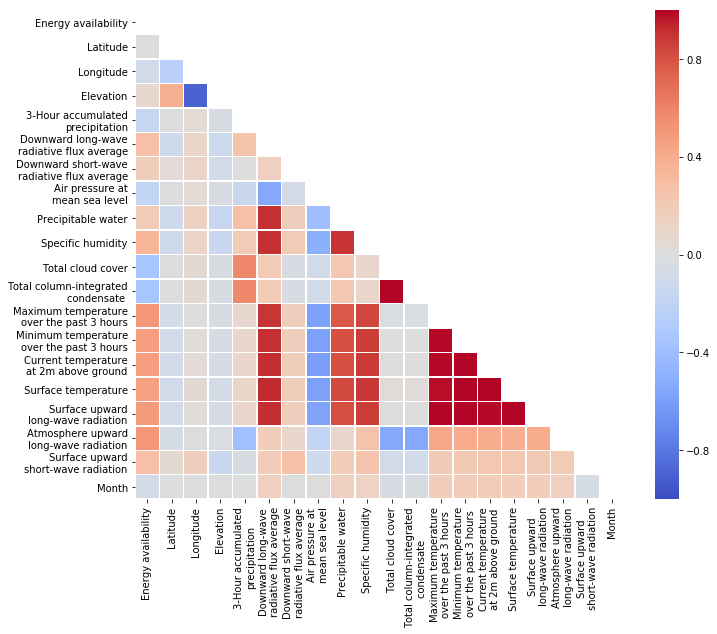

In [11]:
# Extract only forecast hour 0 for the purposes of the below analysis
df_t0 = df.copy()

for col in df_t0.columns:
    if str(col)[-6:-1] == 'fhour':
        if str(col)[-1] != '0':
            del df_t0[col]
            
# Compute the correlation matrix
corr = df_t0.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set column labels
column_labels = ['Energy availability', 'Latitude', 'Longitude', 'Elevation','3-Hour accumulated\nprecipitation', 'Downward long-wave\nradiative flux average','Downward short-wave\nradiative flux average', 'Air pressure at\nmean sea level','Precipitable water', 'Specific humidity','Total cloud cover', 'Total column-integrated\ncondensate ','Maximum temperature\nover the past 3 hours', 'Minimum temperature\nover the past 3 hours','Current temperature\nat 2m above ground', ' Surface temperature','Surface upward\nlong-wave radiation', 'Atmosphere upward\nlong-wave radiation','Surface upward\nshort-wave radiation', 'Month']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, xticklabels=column_labels, yticklabels=column_labels)

plt.savefig('forecasthour0_corr', bbox_inches='tight', pad_inches=0.5)

plt.show()

Many of the features exhibit collinearity. The process of removal from the model is as follows:
- Select all feature sets with pearson correlation coefficient > 0.7 or < -0.7.
- Determine the feature of each feature set that has a higher correlation coefficient when paired with the target variable (energy).
- Add to the list for removal the feature that has lower predictive power.

In [12]:
# Copy correlation dataframe
corr_sort = corr.copy()

# Initialize new DataFrame 
match_corr = pd.DataFrame({'feature_1', 'feature_1_energy_corr' 'feature_2', 'feature_2_energy_corr', 'pearson_corr'})

# Get column labels
column_labels = list(df_t0.columns)

# For each column and row, get two features and their correlation coeff,
# as well as their respective correlation coeffs with the target variable
for i in range(20):
    for j in range(20):
        ij_corr = corr_sort.iloc[:,i].values[j]
        feature_1 = column_labels[i]
        feature_2 = column_labels[j]
        feature_1_energy_corr = corr_sort.iloc[:,0].values[i]
        feature_2_energy_corr = corr_sort.iloc[:,0].values[j]
        temp_df = pd.DataFrame({'feature_1': feature_1,
                                'feature_1_energy_corr': feature_1_energy_corr,
                                'feature_2': feature_2,
                                'feature_2_energy_corr': feature_2_energy_corr,
                                'pearson_corr': [ij_corr]})
        match_corr = match_corr.append(temp_df)

# Reorganize the match correlation dataframe
match_corr = match_corr.reset_index().iloc[3:,2:].sort_values('pearson_corr', ascending=False).reset_index(drop=True).iloc[21:,:].iloc[::2].reset_index(drop=True)
match_corr.head()

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


feature_1  feature_1_energy_corr        feature_2  \
0  tcolc_eatfhour0              -0.344071  tcdc_eatmfhour0   
1  tmin_2m_lfhour0               0.481208  tmp_2m_lafhour0   
2  tmp_sfc_lfhour0               0.465805  tmp_2m_lafhour0   
3  tmin_2m_lfhour0               0.481208  tmp_sfc_lfhour0   
4  tmin_2m_lfhour0               0.481208  ulwrf_sfcfhour0   

   feature_2_energy_corr  pearson_corr  
0              -0.344538      0.999887  
1               0.480886      0.997845  
2               0.480886      0.997628  
3               0.465805      0.995741  
4               0.486807      0.993379

In [13]:
# Select only pearson correlation coefficients > 0.7 or less than -0.7
corr_to_delete = match_corr[(match_corr.pearson_corr > 0.7) | (match_corr.pearson_corr < -0.7)]
corr_to_delete.head()

feature_1  feature_1_energy_corr        feature_2  \
0  tcolc_eatfhour0              -0.344071  tcdc_eatmfhour0   
1  tmin_2m_lfhour0               0.481208  tmp_2m_lafhour0   
2  tmp_sfc_lfhour0               0.465805  tmp_2m_lafhour0   
3  tmin_2m_lfhour0               0.481208  tmp_sfc_lfhour0   
4  tmin_2m_lfhour0               0.481208  ulwrf_sfcfhour0   

   feature_2_energy_corr  pearson_corr  
0              -0.344538      0.999887  
1               0.480886      0.997845  
2               0.480886      0.997628  
3               0.465805      0.995741  
4               0.486807      0.993379

In [14]:
# Create the list of features to delete

features_to_delete = []

for index, row in corr_to_delete.iterrows():
    if np.absolute(row['feature_1_energy_corr']) > np.absolute(row['feature_2_energy_corr']):
        features_to_delete.append(row['feature_2'])        
    else:
        features_to_delete.append(row['feature_1'])  
        
set(features_to_delete)

{'dlwrf_sfcfhour0',
 'elev',
 'pwat_eatmfhour0',
 'spfh_2m_lfhour0',
 'tcolc_eatfhour0',
 'tmin_2m_lfhour0',
 'tmp_2m_lafhour0',
 'tmp_sfc_lfhour0',
 'ulwrf_sfcfhour0'}

### Assumption: Homoscedasticity (constant variance) of residuals

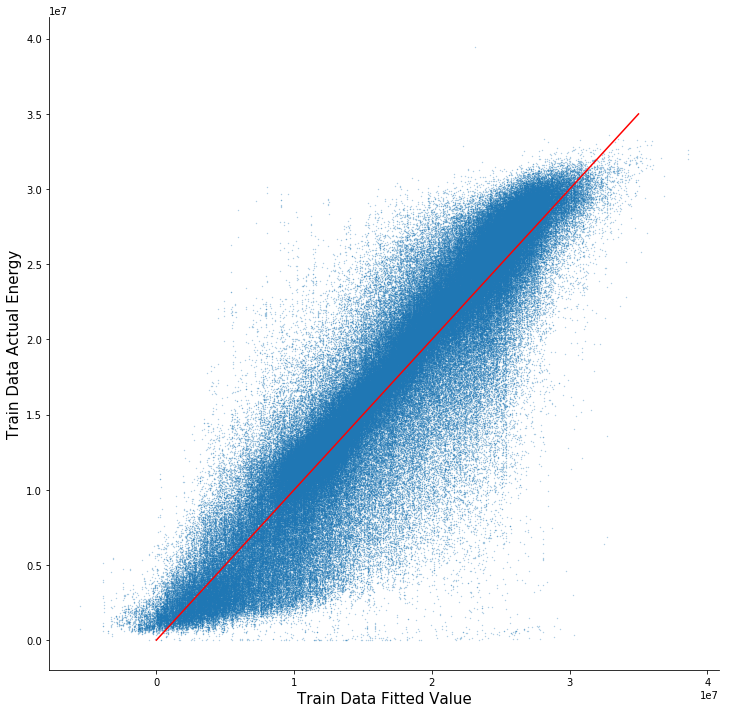

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(m_ols.predict(X_train), y_train, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Train Data Fitted Value", fontsize=15)
plt.ylabel("Train Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_fitted_vs_actual', bbox_inches='tight')

plt.show()

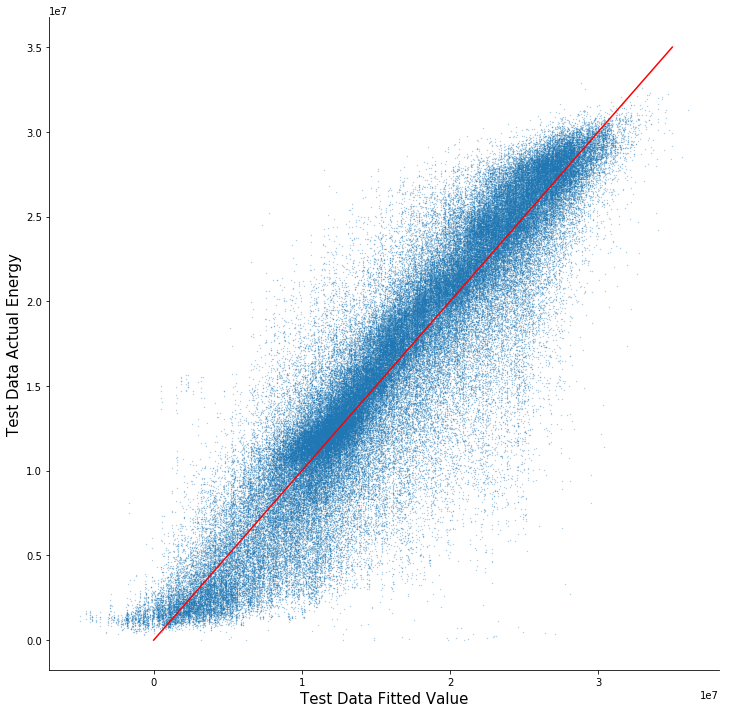

In [59]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(m_ols.predict(X_test), y_test, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_fitted_vs_actual_test', bbox_inches='tight')

plt.show()

-  Using visual inspection, we can see that the residuals do not exhibit constant variance. Lower energy values are overestimated and higher energy values are underestimated. 

In [19]:
_, _, f_value, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(m_ols.resid, df_ols_train.iloc[:,1:])

In [20]:
print('bp test f_value: ' + str(f_value))
print('bp test f_pvalue: ' + str(f_pvalue))

bp test f_value: 1191.1812292039979
bp test f_pvalue: 0.0


- the very low p-value indicates a very likely violation of homoscedasticity (constant variance)

### Assumption: Normally distributed residuals

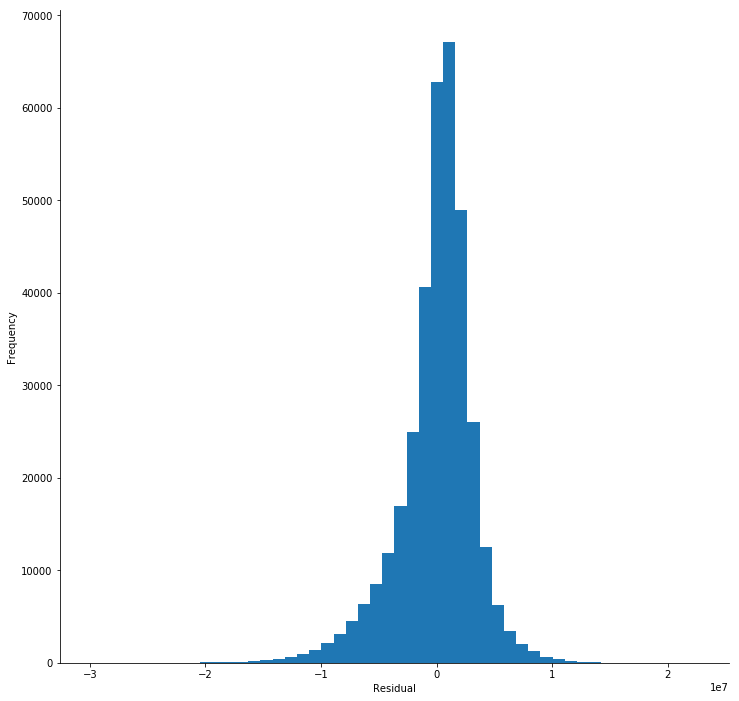

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
plt.hist(m_ols.resid, bins=50)
plt.xlabel("Residual")
plt.ylabel("Frequency")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_residuals_histogram', bbox_inches='tight')

plt.show()

In [22]:
statsmodels.stats.diagnostic.normal_ad(m_ols.resid)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


(6110.378330328851, 0.0)

- The Anderson-Darling Normality test has the null hypothesis that the data is normally distributed. The p-value of the test statistic is very small, thus we reject the null hypothesis that the data is normally distributed.

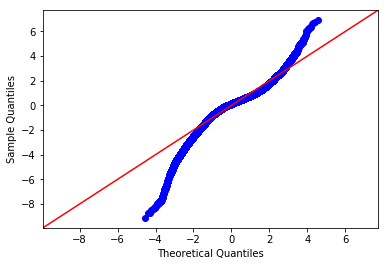

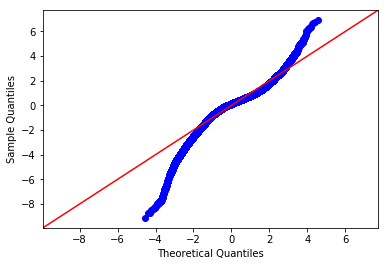

In [23]:
qqplot(m_ols.resid, line='45', fit=True)

- The Q-Q plot shows that the issues with the model are at the tails (low and high values). It also confirms the non-normally distributed residuals. 

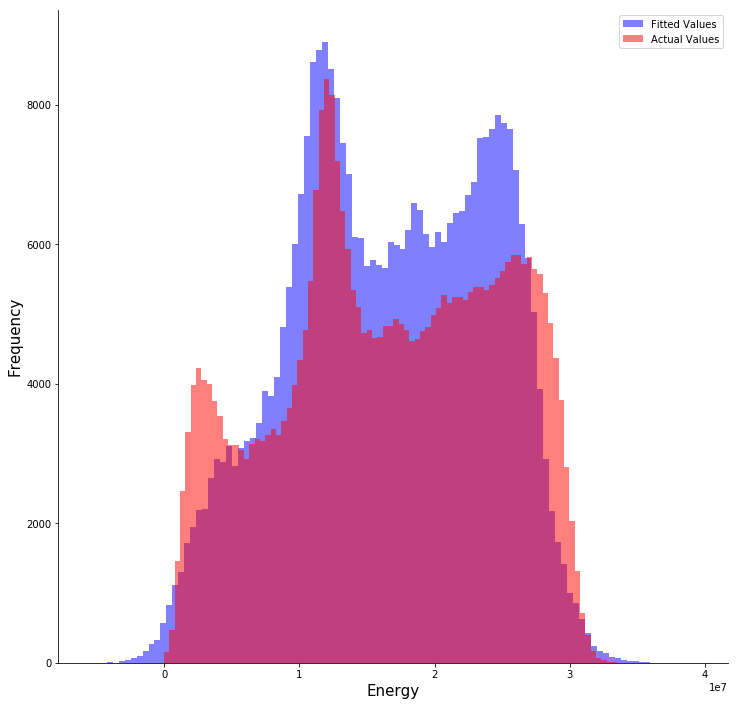

In [24]:
fig, ax = plt.subplots(figsize=(12,12))
plt.hist(m_ols.predict(X_train), bins=100, color='blue', alpha=0.5)
plt.hist(y_train, bins=100, color='red', alpha=0.5)

plt.xlabel("Energy", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(['Fitted Values', 'Actual Values'])

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.show()

## Conclusions

- Multicollinearity between many variables (only forecast hour 0 variables were checked - for now).
    - These variables are to be removed to build the next model (1b).
- Residuals violate Homoscedasticity (constant variance).
- Residuals are non-normal.
- The model does have predictive power:
    - R2 = 0.833
    - Test data adj. R2 = 0.915
    - MAE on the scale of ~10-15% of average energy values

# Model 1b: OLS - REDUCED FEATURES

In [25]:
df_ols_fs = df.copy()
del df_ols_fs['elev']
del df_ols_fs['dlwrf_sfcfhour0']
del df_ols_fs['dlwrf_sfcfhour1']
del df_ols_fs['dlwrf_sfcfhour2']
del df_ols_fs['dlwrf_sfcfhour3']
del df_ols_fs['dlwrf_sfcfhour4']
del df_ols_fs['pwat_eatmfhour0']
del df_ols_fs['pwat_eatmfhour1']
del df_ols_fs['pwat_eatmfhour2']
del df_ols_fs['pwat_eatmfhour3']
del df_ols_fs['pwat_eatmfhour4']
del df_ols_fs['spfh_2m_lfhour0']
del df_ols_fs['spfh_2m_lfhour1']
del df_ols_fs['spfh_2m_lfhour2']
del df_ols_fs['spfh_2m_lfhour3']
del df_ols_fs['spfh_2m_lfhour4']
del df_ols_fs['tcolc_eatfhour0']
del df_ols_fs['tcolc_eatfhour1']
del df_ols_fs['tcolc_eatfhour2']
del df_ols_fs['tcolc_eatfhour3']
del df_ols_fs['tcolc_eatfhour4']
del df_ols_fs['tmin_2m_lfhour0']
del df_ols_fs['tmin_2m_lfhour1']
del df_ols_fs['tmin_2m_lfhour2']
del df_ols_fs['tmin_2m_lfhour3']
del df_ols_fs['tmin_2m_lfhour4']
del df_ols_fs['tmp_2m_lafhour0']
del df_ols_fs['tmp_2m_lafhour1']
del df_ols_fs['tmp_2m_lafhour2']
del df_ols_fs['tmp_2m_lafhour3']
del df_ols_fs['tmp_2m_lafhour4']
del df_ols_fs['tmp_sfc_lfhour0']
del df_ols_fs['tmp_sfc_lfhour1']
del df_ols_fs['tmp_sfc_lfhour2']
del df_ols_fs['tmp_sfc_lfhour3']
del df_ols_fs['tmp_sfc_lfhour4']
del df_ols_fs['ulwrf_sfcfhour0']
del df_ols_fs['ulwrf_sfcfhour1']
del df_ols_fs['ulwrf_sfcfhour2']
del df_ols_fs['ulwrf_sfcfhour3']
del df_ols_fs['ulwrf_sfcfhour4']
df_ols_fs.head()

energy      nlat       elon  apcp_sfc_fhour0  apcp_sfc_fhour1  \
Date                                                                          
1994-01-01  12384900  34.80833  261.97675              0.0              0.0   
1994-01-02  11908500  34.80833  261.97675              0.0              0.0   
1994-01-03  12470700  34.80833  261.97675              0.0              0.0   
1994-01-04  12725400  34.80833  261.97675              0.0              0.0   
1994-01-05  10894800  34.80833  261.97675              0.0              0.0   

            apcp_sfc_fhour2  apcp_sfc_fhour3  apcp_sfc_fhour4  \
Date                                                            
1994-01-01              0.0             0.00              0.0   
1994-01-02              0.0             0.01              0.1   
1994-01-03              0.0             0.00              0.0   
1994-01-04              0.0             0.00              0.0   
1994-01-05              0.0             0.00              0.0   

            dswrf_sfcfhour0  dswrf_sfcfhour1  ...  ulwrf_tatfhour1  \
Date                                          ...                    
1994-01-01              0.0             30.0  ...        250.69777   
1994-01-02              0.0             30.0  ...        232.06482   
1994-01-03              0.0             30.0  ...        232.01129   
1994-01-04              0.0             30.0  ...        243.53894   
1994-01-05              0.0             30.0  ...        235.32010   

            ulwrf_tatfhour2  ulwrf_tatfhour3  ulwrf_tatfhour4  \
Date                                                            
1994-01-01        253.00000        263.59940        260.80518   
1994-01-02        232.53503        231.00787        232.05087   
1994-01-03        235.49771        252.00594        247.46686   
1994-01-04        245.44907        254.23553        250.00110   
1994-01-05        242.18672        258.26974        241.10945   

            uswrf_sfcfhour0  uswrf_sfcfhour1  uswrf_sfcfhour2  \
Date                                                            
1994-01-01              0.0              9.0             49.0   
1994-01-02              0.0              8.0             35.0   
1994-01-03              0.0              9.0             50.0   
1994-01-04              0.0              9.0             50.0   
1994-01-05              0.0              8.0             48.0   

            uswrf_sfcfhour3  uswrf_sfcfhour4  month  
Date                                                 
1994-01-01            107.0             74.0      1  
1994-01-02             73.0             49.0      1  
1994-01-03            111.0             75.0      1  
1994-01-04            112.0             77.0      1  
1994-01-05            107.0             71.0      1  

[5 rows x 39 columns]

In [70]:
df_ols_train = df_ols_fs.copy()
df_ols_train = df_ols_train.loc['1994':'2003']

In [71]:
X_train = df_ols_fs.loc['1994':'2003'].iloc[:, 1:]
y_train = df_ols_fs.energy.loc['1994':'2003']
X_test = df_ols_fs.loc['2004':'2007'].iloc[:, 1:]
y_test = df_ols_fs.energy.loc['2004':'2007']

In [28]:
average_cv, cv_scores = cv_score('ols', X_train, y_train, score_func=mean_absolute_error)
print('Average CV MAE: %.0f' % average_cv)
cv_scores.reset_index(drop=True)

Average CV MAE: 2552359


fold        cv_mae
0     1  2.566463e+06
1     2  2.710668e+06
2     3  2.512899e+06
3     4  2.494740e+06
4     5  2.477026e+06

In [29]:
ols_string = 'energy ~ ' + ''.join([i + ' + ' for i in df_ols_train.columns[1:]])[:-3]
m_ols_fs = ols(ols_string,df_ols_train).fit()
print('MAE: %.0f' % mean_absolute_error(m_ols_fs.predict(X_test), y_test))
print(m_ols_fs.summary())

MAE: 2360389
                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                 3.949e+04
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:39:17   Log-Likelihood:            -5.8615e+06
No. Observations:              355413   AIC:                         1.172e+07
Df Residuals:                  355374   BIC:                         1.172e+07
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.883e+07   

In [133]:
# Calculate test data Pearson R
model_1b_test_pearson = pearsonr(m_ols_fs.predict(X_test), y_test)
model_1b_test_pearson_adj = 1 - (1 - model_1b_test_pearson[0]) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
model_1b_test_pearson_adj

0.9013971811887057

## 1b OLS - REDUCED FEATURES Model Evaluation

### Assumption: Linear relationship between target variables and features exists

Analyzing the regression coefficients above, we can see that rises or falls in each of the features are associated with rises or falls in target variable. 

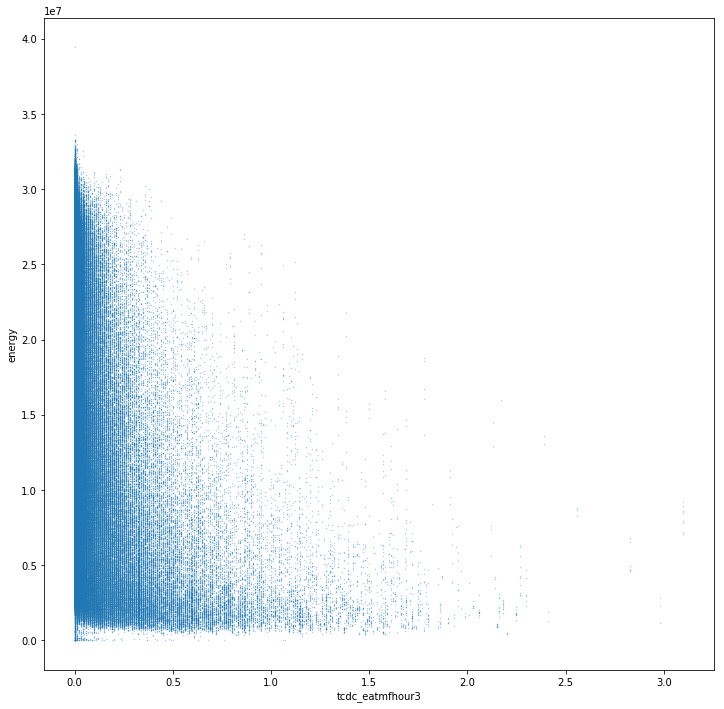

In [30]:
plt.subplots(figsize=(12,12))
plt.scatter(df['tcdc_eatmfhour3'], df['energy'], s=0.1, alpha=0.5)
plt.xlabel('tcdc_eatmfhour3')
plt.ylabel('energy')
plt.show()

- There is a relationship between the two variables, but it appears to not be very linear.

### Assumption: No multicollinearity in the data

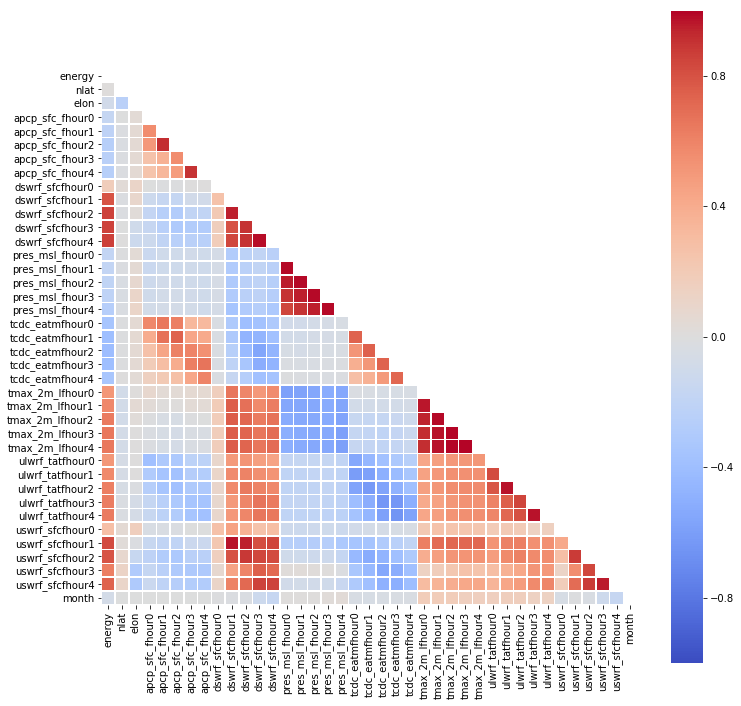

In [31]:
# Compute the correlation matrix
corr = df_ols_fs.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,12))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5)

plt.show()

Many of the features exhibit multicollinearity. The process of removal from the model is as follows:
- Select all feature sets with pearson correlation coefficient > 0.7 or < -0.7.
- Determine the feature of each feature set that has a higher correlation coefficient when paired with the target variable (energy).
- Add to the list for removal the feature that has lower predictive power.

In [32]:
# Copy correlation dataframe
corr_sort = corr.copy()

# Initialize new DataFrame 
match_corr = pd.DataFrame({'feature_1', 'feature_1_energy_corr' 'feature_2', 'feature_2_energy_corr', 'pearson_corr'})

# Get column labels
column_labels = list(df_ols_fs.columns)

# For each column and row, get two features and their correlation coeff,
# as well as their respective correlation coeffs with the target variable
for i in range(39):
    for j in range(39):
        ij_corr = corr_sort.iloc[:,i].values[j]
        feature_1 = column_labels[i]
        feature_2 = column_labels[j]
        feature_1_energy_corr = corr_sort.iloc[:,0].values[i]
        feature_2_energy_corr = corr_sort.iloc[:,0].values[j]
        temp_df = pd.DataFrame({'feature_1': feature_1,
                                'feature_1_energy_corr': feature_1_energy_corr,
                                'feature_2': feature_2,
                                'feature_2_energy_corr': feature_2_energy_corr,
                                'pearson_corr': [ij_corr]})
        match_corr = match_corr.append(temp_df)

# Reorganize the match correlation dataframe
match_corr = match_corr.reset_index().iloc[3:,2:].sort_values('pearson_corr', ascending=False).reset_index(drop=True).iloc[39:,:].iloc[::2].reset_index(drop=True)
match_corr

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


feature_1  feature_1_energy_corr        feature_2  \
0    tmax_2m_lfhour4               0.652659  tmax_2m_lfhour3   
1    tmax_2m_lfhour2               0.635625  tmax_2m_lfhour3   
2    tmax_2m_lfhour4               0.652659  tmax_2m_lfhour2   
3    pres_msl_fhour0              -0.182062  pres_msl_fhour1   
4    pres_msl_fhour2              -0.196069  pres_msl_fhour3   
5    pres_msl_fhour2              -0.196069  pres_msl_fhour1   
6    tmax_2m_lfhour2               0.635625  tmax_2m_lfhour1   
7    pres_msl_fhour4              -0.259551  pres_msl_fhour3   
8    dswrf_sfcfhour3               0.855148  dswrf_sfcfhour4   
9    dswrf_sfcfhour1               0.796179  uswrf_sfcfhour1   
10   ulwrf_tatfhour4               0.639518  ulwrf_tatfhour3   
11   ulwrf_tatfhour1               0.574889  ulwrf_tatfhour2   
12   tmax_2m_lfhour1               0.584497  tmax_2m_lfhour3   
13   tmax_2m_lfhour1               0.584497  tmax_2m_lfhour4   
14   tmax_2m_lfhour0               0.510565  tmax_2m_lfhour1   
15   uswrf_sfcfhour4               0.741382  uswrf_sfcfhour3   
16   pres_msl_fhour2              -0.196069  pres_msl_fhour0   
17   pres_msl_fhour4              -0.259551  pres_msl_fhour2   
18   pres_msl_fhour1              -0.185386  pres_msl_fhour3   
19   dswrf_sfcfhour1               0.796179  dswrf_sfcfhour2   
20   uswrf_sfcfhour1               0.821484  dswrf_sfcfhour2   
21   tmax_2m_lfhour2               0.635625  tmax_2m_lfhour0   
22   tmax_2m_lfhour3               0.653344  tmax_2m_lfhour0   
23   tmax_2m_lfhour0               0.510565  tmax_2m_lfhour4   
24   apcp_sfc_fhour1              -0.218737  apcp_sfc_fhour2   
25   dswrf_sfcfhour2               0.854405  dswrf_sfcfhour3   
26   dswrf_sfcfhour2               0.854405  dswrf_sfcfhour4   
27   pres_msl_fhour1              -0.185386  pres_msl_fhour4   
28   pres_msl_fhour3              -0.204033  pres_msl_fhour0   
29   apcp_sfc_fhour3              -0.241644  apcp_sfc_fhour4   
..               ...                    ...              ...   
712  tmax_2m_lfhour2               0.635625  pres_msl_fhour2   
713  tmax_2m_lfhour3               0.653344  pres_msl_fhour3   
714  tmax_2m_lfhour3               0.653344  pres_msl_fhour2   
715  tmax_2m_lfhour0               0.510565  pres_msl_fhour4   
716  pres_msl_fhour2              -0.196069  tmax_2m_lfhour4   
717  tmax_2m_lfhour4               0.652659  pres_msl_fhour3   
718  pres_msl_fhour2              -0.196069  tmax_2m_lfhour1   
719  ulwrf_tatfhour0               0.508163  tcdc_eatmfhour0   
720  tcdc_eatmfhour2              -0.409670  uswrf_sfcfhour3   
721  tmax_2m_lfhour1               0.584497  pres_msl_fhour0   
722  pres_msl_fhour2              -0.196069  tmax_2m_lfhour0   
723  pres_msl_fhour1              -0.185386  tmax_2m_lfhour1   
724  pres_msl_fhour4              -0.259551  tmax_2m_lfhour1   
725  dswrf_sfcfhour3               0.855148  tcdc_eatmfhour2   
726  tcdc_eatmfhour0              -0.344538  ulwrf_tatfhour2   
727  tmax_2m_lfhour2               0.635625  pres_msl_fhour4   
728  ulwrf_tatfhour2               0.619397  tcdc_eatmfhour2   
729  ulwrf_tatfhour4               0.639518  tcdc_eatmfhour4   
730  pres_msl_fhour1              -0.185386  tmax_2m_lfhour0   
731  tcdc_eatmfhour2              -0.409670  ulwrf_tatfhour4   
732  pres_msl_fhour4              -0.259551  tmax_2m_lfhour3   
733  tcdc_eatmfhour1              -0.391369  ulwrf_tatfhour1   
734  tmax_2m_lfhour0               0.510565  pres_msl_fhour0   
735  pres_msl_fhour4              -0.259551  tmax_2m_lfhour4   
736  tcdc_eatmfhour0              -0.344538  ulwrf_tatfhour1   
737  tcdc_eatmfhour1              -0.391369  ulwrf_tatfhour2   
738  ulwrf_tatfhour3               0.631256  tcdc_eatmfhour3   
739  tcdc_eatmfhour2              -0.409670  ulwrf_tatfhour3   
740  ulwrf_tatfhour4               0.639518  tcdc_eatmfhour3   
741              NaN                    NaN              NaN   

     feature_2_energy_corr  pearson_corr  

In [33]:
# Select only pearson correlation coefficients > 0.7 or less than -0.7
corr_to_delete = match_corr[(match_corr.pearson_corr > 0.7) | (match_corr.pearson_corr < -0.7)]
corr_to_delete

feature_1  feature_1_energy_corr        feature_2  \
0   tmax_2m_lfhour4               0.652659  tmax_2m_lfhour3   
1   tmax_2m_lfhour2               0.635625  tmax_2m_lfhour3   
2   tmax_2m_lfhour4               0.652659  tmax_2m_lfhour2   
3   pres_msl_fhour0              -0.182062  pres_msl_fhour1   
4   pres_msl_fhour2              -0.196069  pres_msl_fhour3   
5   pres_msl_fhour2              -0.196069  pres_msl_fhour1   
6   tmax_2m_lfhour2               0.635625  tmax_2m_lfhour1   
7   pres_msl_fhour4              -0.259551  pres_msl_fhour3   
8   dswrf_sfcfhour3               0.855148  dswrf_sfcfhour4   
9   dswrf_sfcfhour1               0.796179  uswrf_sfcfhour1   
10  ulwrf_tatfhour4               0.639518  ulwrf_tatfhour3   
11  ulwrf_tatfhour1               0.574889  ulwrf_tatfhour2   
12  tmax_2m_lfhour1               0.584497  tmax_2m_lfhour3   
13  tmax_2m_lfhour1               0.584497  tmax_2m_lfhour4   
14  tmax_2m_lfhour0               0.510565  tmax_2m_lfhour1   
15  uswrf_sfcfhour4               0.741382  uswrf_sfcfhour3   
16  pres_msl_fhour2              -0.196069  pres_msl_fhour0   
17  pres_msl_fhour4              -0.259551  pres_msl_fhour2   
18  pres_msl_fhour1              -0.185386  pres_msl_fhour3   
19  dswrf_sfcfhour1               0.796179  dswrf_sfcfhour2   
20  uswrf_sfcfhour1               0.821484  dswrf_sfcfhour2   
21  tmax_2m_lfhour2               0.635625  tmax_2m_lfhour0   
22  tmax_2m_lfhour3               0.653344  tmax_2m_lfhour0   
23  tmax_2m_lfhour0               0.510565  tmax_2m_lfhour4   
24  apcp_sfc_fhour1              -0.218737  apcp_sfc_fhour2   
25  dswrf_sfcfhour2               0.854405  dswrf_sfcfhour3   
26  dswrf_sfcfhour2               0.854405  dswrf_sfcfhour4   
27  pres_msl_fhour1              -0.185386  pres_msl_fhour4   
28  pres_msl_fhour3              -0.204033  pres_msl_fhour0   
29  apcp_sfc_fhour3              -0.241644  apcp_sfc_fhour4   
..              ...                    ...              ...   
47  dswrf_sfcfhour3               0.855148  uswrf_sfcfhour1   
48  ulwrf_tatfhour4               0.639518  ulwrf_tatfhour2   
49  dswrf_sfcfhour3               0.855148  dswrf_sfcfhour1   
50  dswrf_sfcfhour1               0.796179  uswrf_sfcfhour2   
51  dswrf_sfcfhour1               0.796179           energy   
52           energy               1.000000  uswrf_sfcfhour2   
53  ulwrf_tatfhour0               0.508163  ulwrf_tatfhour2   
54  dswrf_sfcfhour1               0.796179  tmax_2m_lfhour2   
55  tmax_2m_lfhour3               0.653344  dswrf_sfcfhour1   
56  tmax_2m_lfhour4               0.652659  dswrf_sfcfhour1   
57  tmax_2m_lfhour1               0.584497  dswrf_sfcfhour1   
58  dswrf_sfcfhour3               0.855148  uswrf_sfcfhour3   
59  ulwrf_tatfhour1               0.574889  ulwrf_tatfhour3   
60  tcdc_eatmfhour2              -0.409670  tcdc_eatmfhour1   
61  uswrf_sfcfhour4               0.741382           energy   
62  tcdc_eatmfhour0              -0.344538  tcdc_eatmfhour1   
63  apcp_sfc_fhour2              -0.256561  tcdc_eatmfhour1   
64  tcdc_eatmfhour3              -0.397249  tcdc_eatmfhour2   
65  tmax_2m_lfhour3               0.653344  dswrf_sfcfhour2   
66  dswrf_sfcfhour2               0.854405  tmax_2m_lfhour4   
67  dswrf_sfcfhour2               0.854405  tmax_2m_lfhour2   
68  uswrf_sfcfhour1               0.821484  tmax_2m_lfhour2   
69  tcdc_eatmfhour4              -0.336458  tcdc_eatmfhour3   
70  uswrf_sfcfhour1               0.821484  tmax_2m_lfhour3   
71  ulwrf_tatfhour1               0.574889  ulwrf_tatfhour4   
72  uswrf_sfcfhour1               0.821484  tmax_2m_lfhour4   
73  dswrf_sfcfhour2               0.854405  uswrf_sfcfhour4   
74  uswrf_sfcfhour3               0.619892  dswrf_sfcfhour4   
75  tmax_2m_lfhour1               0.584497  uswrf_sfcfhour1   
76  uswrf_sfcfhour4               0.741382  uswrf_sfcfhour1   

    feature_2_energy_corr  pearson_corr  
0                0.653344      0.999824  
1                0.

In [34]:
# Create the list of features to delete

features_to_delete = []

for index, row in corr_to_delete.iterrows():
    if np.absolute(row['feature_1_energy_corr']) > np.absolute(row['feature_2_energy_corr']):
        features_to_delete.append(row['feature_2'])        
    else:
        features_to_delete.append(row['feature_1'])  
        
set(features_to_delete)

{'apcp_sfc_fhour1',
 'apcp_sfc_fhour2',
 'apcp_sfc_fhour3',
 'dswrf_sfcfhour1',
 'dswrf_sfcfhour2',
 'dswrf_sfcfhour3',
 'dswrf_sfcfhour4',
 'pres_msl_fhour0',
 'pres_msl_fhour1',
 'pres_msl_fhour2',
 'pres_msl_fhour3',
 'tcdc_eatmfhour0',
 'tcdc_eatmfhour1',
 'tcdc_eatmfhour3',
 'tcdc_eatmfhour4',
 'tmax_2m_lfhour0',
 'tmax_2m_lfhour1',
 'tmax_2m_lfhour2',
 'tmax_2m_lfhour3',
 'tmax_2m_lfhour4',
 'ulwrf_tatfhour0',
 'ulwrf_tatfhour1',
 'ulwrf_tatfhour2',
 'ulwrf_tatfhour3',
 'uswrf_sfcfhour1',
 'uswrf_sfcfhour2',
 'uswrf_sfcfhour3',
 'uswrf_sfcfhour4'}

### Assumption: Homoscedasticity (constant variance) of residuals

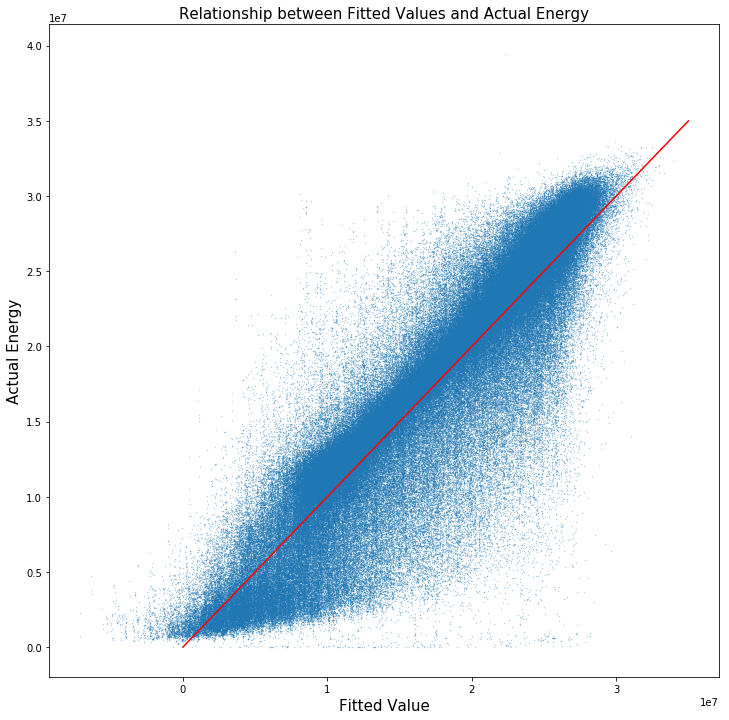

In [35]:
plt.subplots(figsize=(12, 12))
plt.scatter(m_ols_fs.predict(X_train), y_train, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Fitted Value", fontsize=15)
plt.ylabel("Actual Energy", fontsize=15)
plt.title("Relationship between Fitted Values and Actual Energy", fontsize=15)
plt.show()

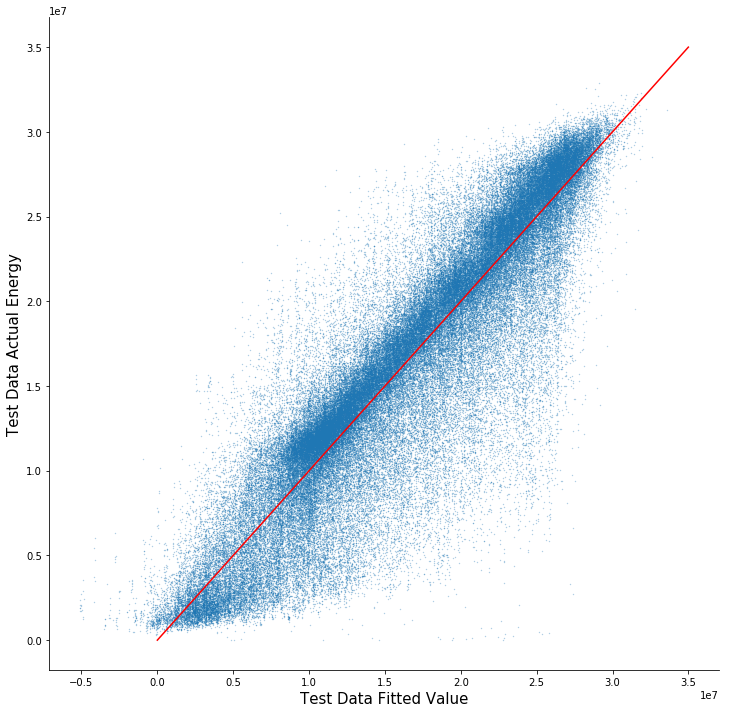

In [65]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(m_ols_fs.predict(X_test), y_test, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1b_fitted_vs_actual_test', bbox_inches='tight')

plt.show()

-  Using visual inspection, we can see that the residuals do not exhibit constant variance. Lower energy values are overestimated and higher energy values are underestimated. 

In [36]:
_, _, f_value, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(m_ols_fs.resid, df_ols_train.iloc[:,1:])

In [37]:
print('bp test f_value: ' + str(f_value))
print('bp test f_pvalue: ' + str(f_pvalue))

bp test f_value: 2337.970605949015
bp test f_pvalue: 0.0


- the very low p-value indicates a very likely violation of homoscedasticity (constant variance)

### Assumption: Normally distributed residuals

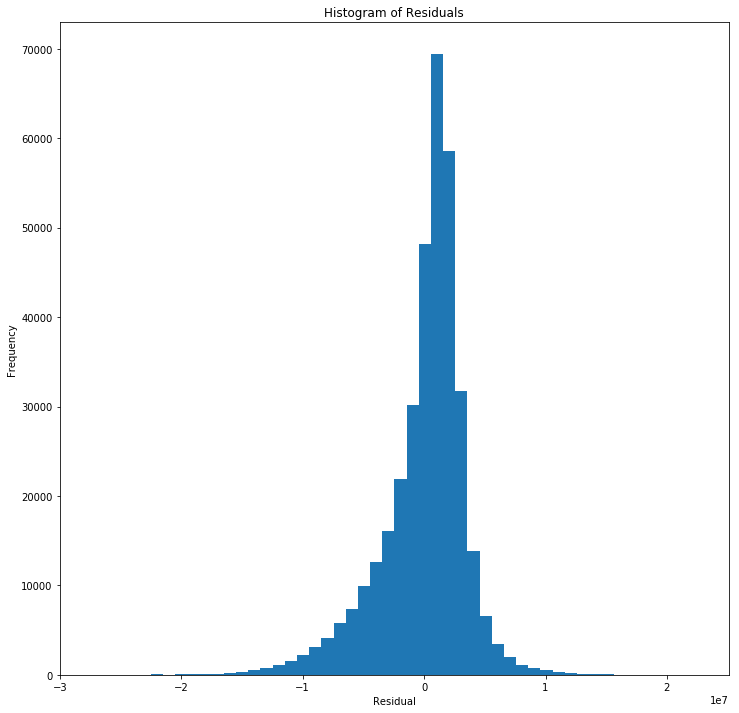

In [38]:
plt.subplots(figsize=(12,12))
plt.hist(m_ols_fs.resid, bins=50)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [39]:
statsmodels.stats.diagnostic.normal_ad(m_ols_fs.resid)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


(8937.939704370976, 0.0)

- The Anderson-Darling Normality test has the null hypothesis that the data is normally distributed. The p-value of the test statistic is very small, thus we reject the null hypothesis that the data is normally distributed.

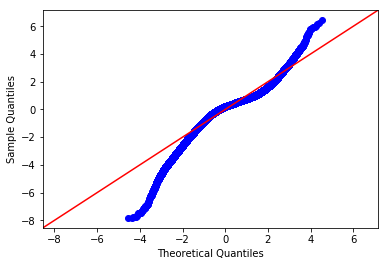

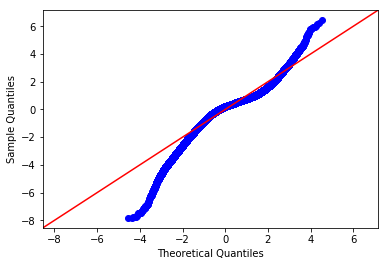

In [40]:
qqplot(m_ols_fs.resid, line='45', fit=True)

- The Q-Q plot shows that the issues with the model are at the tails (low and high values). It also confirms the non-normally distributed residuals. 

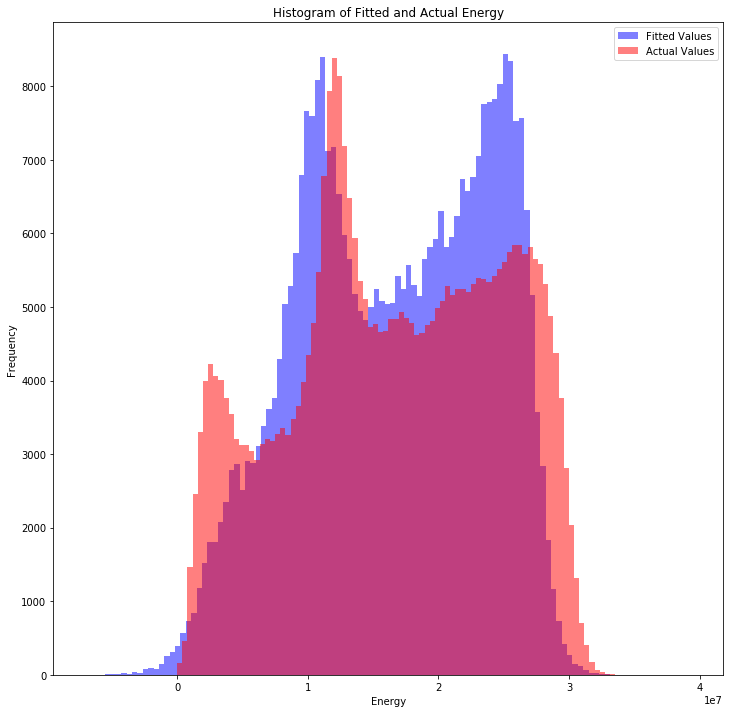

In [41]:
plt.subplots(figsize=(12,12))
plt.hist(m_ols_fs.predict(X_train), bins=100, color='blue', alpha=0.5)
plt.hist(y_train, bins=100, color='red', alpha=0.5)
plt.title("Histogram of Fitted and Actual Energy")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend(['Fitted Values', 'Actual Values'])
plt.show()

## Conclusions

- Multicollinearity between many variables (only forecast hour 0 variables checked last time - there is still multicollinearity between forecast hours).
    - These variables are to be removed to build the next model (1c).
- Residuals violate Homoscedasticity (constant variance).
- Residuals are non-normal.
- The model does have predictive power:
    - R2 = 0.809
    - Test data adj. R2 = 0.901
    - MAE on the scale of ~10-15% of average energy values

# Model 1c: OLS - FURTHER REDUCED FEATURES

In [42]:
df_ols_fs2 = df_ols_fs.copy()

del df_ols_fs2['apcp_sfc_fhour1']
del df_ols_fs2['apcp_sfc_fhour2']
del df_ols_fs2['apcp_sfc_fhour3']
del df_ols_fs2['dswrf_sfcfhour2']
del df_ols_fs2['dswrf_sfcfhour3']
del df_ols_fs2['dswrf_sfcfhour4']
del df_ols_fs2['pres_msl_fhour0']
del df_ols_fs2['pres_msl_fhour1']
del df_ols_fs2['pres_msl_fhour2']
del df_ols_fs2['pres_msl_fhour3']
del df_ols_fs2['tcdc_eatmfhour0']
del df_ols_fs2['tcdc_eatmfhour1']
del df_ols_fs2['tcdc_eatmfhour3']
del df_ols_fs2['tcdc_eatmfhour4']
del df_ols_fs2['tmax_2m_lfhour0']
del df_ols_fs2['tmax_2m_lfhour1']
del df_ols_fs2['tmax_2m_lfhour2']
del df_ols_fs2['tmax_2m_lfhour3']
del df_ols_fs2['tmax_2m_lfhour4']
del df_ols_fs2['ulwrf_tatfhour0']
del df_ols_fs2['ulwrf_tatfhour1']
del df_ols_fs2['ulwrf_tatfhour2']
del df_ols_fs2['ulwrf_tatfhour3']
del df_ols_fs2['uswrf_sfcfhour1']
del df_ols_fs2['uswrf_sfcfhour2']
del df_ols_fs2['uswrf_sfcfhour3']
del df_ols_fs2['uswrf_sfcfhour4']

In [76]:
df_ols_fs2_train = df_ols_fs2.copy()
df_ols_fs2_train = df_ols_fs2_train.loc['1994':'2003']

In [77]:
X_train = df_ols_fs2.loc['1994':'2003'].iloc[:, 1:]
y_train = df_ols_fs2.energy.loc['1994':'2003']
X_test = df_ols_fs2.loc['2004':'2007'].iloc[:, 1:]
y_test = df_ols_fs2.energy.loc['2004':'2007']

In [45]:
average_cv, cv_scores = cv_score('ols', X_train, y_train, score_func=mean_absolute_error)
print('Average CV MAE: %.0f' % average_cv)
cv_scores.reset_index(drop=True)

Average CV MAE: 3021995


fold        cv_mae
0     1  3.039133e+06
1     2  3.205619e+06
2     3  2.959474e+06
3     4  2.931003e+06
4     5  2.974744e+06

In [46]:
ols_string = 'energy ~ ' + ''.join([i + ' + ' for i in df_ols_fs2_train.columns[1:]])[:-3]

m_ols_fs2 = ols(ols_string,df_ols_fs2_train).fit()
print('MAE: %.0f' % mean_absolute_error(m_ols_fs2.predict(X_test), y_test))
print(m_ols_fs2.summary())

MAE: 2844928
                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 9.646e+04
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:40:36   Log-Likelihood:            -5.9095e+06
No. Observations:              355413   AIC:                         1.182e+07
Df Residuals:                  355401   BIC:                         1.182e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.535e+07   

In [134]:
# Calculate test data Pearson R
model_1c_test_pearson = pearsonr(m_ols_fs2.predict(X_test), y_test)
model_1c_test_pearson_adj = 1 - (1 - model_1c_test_pearson[0]) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
model_1c_test_pearson_adj

0.8670855770488897

## 1c OLS - FURTHER REDUCED FEATURES Model Evaluation

### Assumption: Linear relationship between target variables and features exists

Analyzing the regression coefficients above, we can see that rises or falls in each of the features are associated with rises or falls in target variable. 

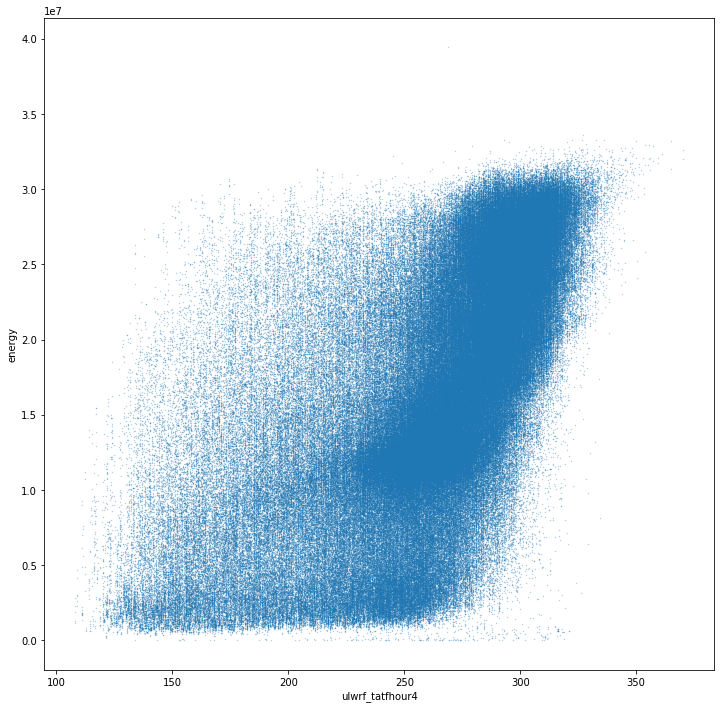

In [47]:
plt.subplots(figsize=(12,12))
plt.scatter(df['ulwrf_tatfhour4'], df['energy'], s=0.1, alpha=0.5)
plt.xlabel('ulwrf_tatfhour4')
plt.ylabel('energy')
plt.show()

- The scatterplot shows a somewhat linear relationship between energy and the feature. 

### Assumption: No multicollinearity in the data

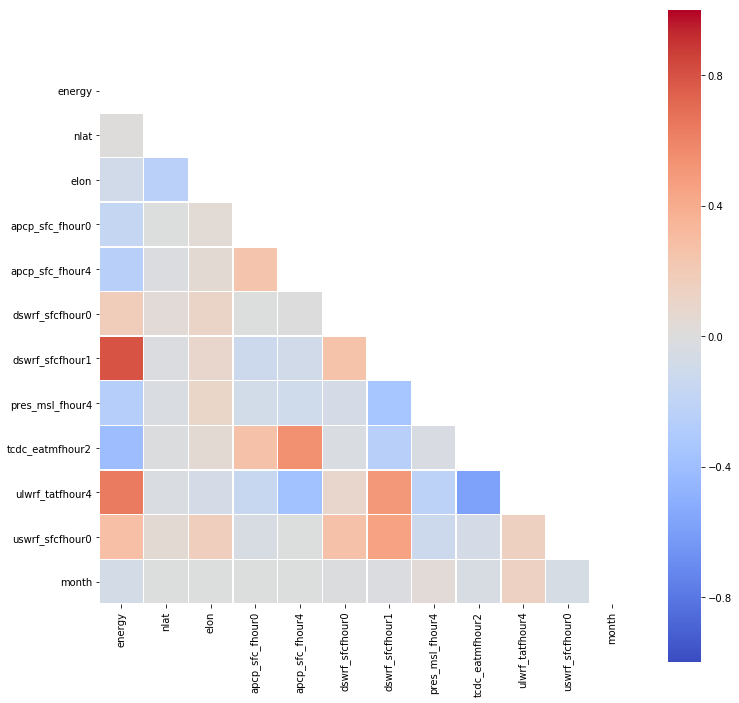

In [48]:
# Compute the correlation matrix
corr = df_ols_fs2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,12))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5)

plt.show()

- The features do not exhibit very strong multicollinearity.

### Assumption: Homoscedasticity (constant variance) of residuals

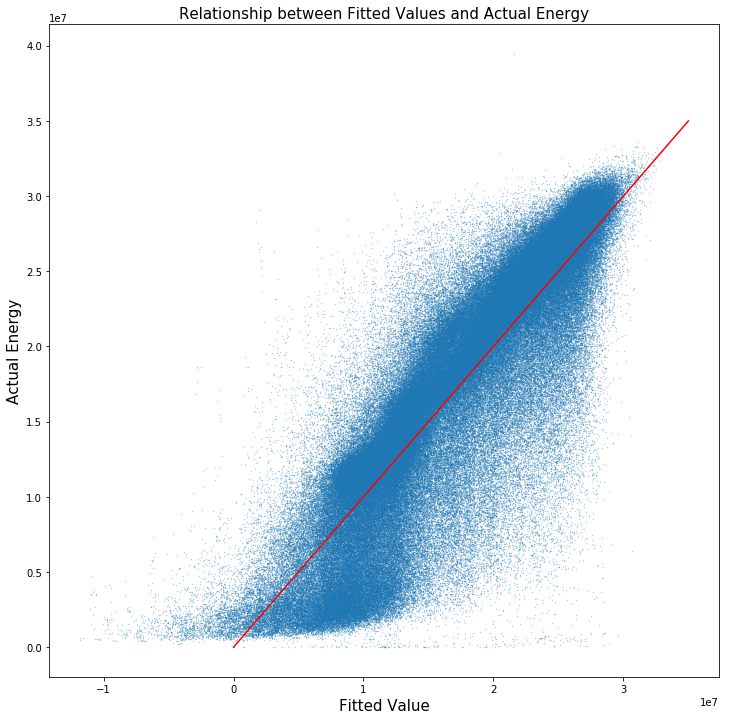

In [49]:
plt.subplots(figsize=(12, 12))
plt.scatter(m_ols_fs2.predict(X_train), y_train, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Fitted Value", fontsize=15)
plt.ylabel("Actual Energy", fontsize=15)
plt.title("Relationship between Fitted Values and Actual Energy", fontsize=15)
plt.show()

-  Using visual inspection, we can see that the residuals do not exhibit constant variance. Lower energy values are underestimated and higher energy values are overestimated. 

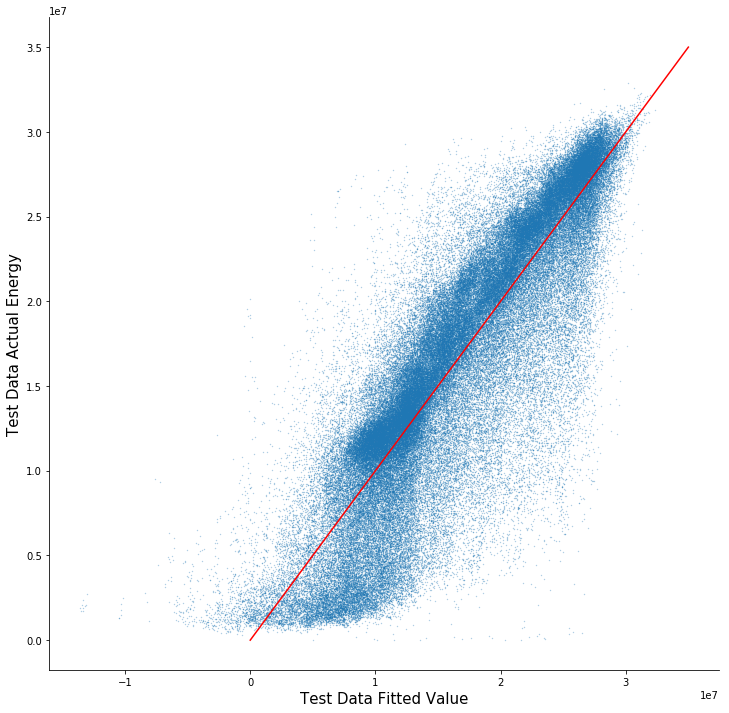

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(m_ols_fs2.predict(X_test), y_test, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1c_fitted_vs_actual_test', bbox_inches='tight')

plt.show()

In [50]:
_, _, f_value, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(m_ols_fs2.resid, df_ols_train.iloc[:,1:])

In [51]:
print('bp test f_value: ' + str(f_value))
print('bp test f_pvalue: ' + str(f_pvalue))

bp test f_value: 3097.929369731086
bp test f_pvalue: 0.0


- the very low p-value indicates a very likely violation of homoscedasticity (constant variance)

### Assumption: Normally distributed residuals

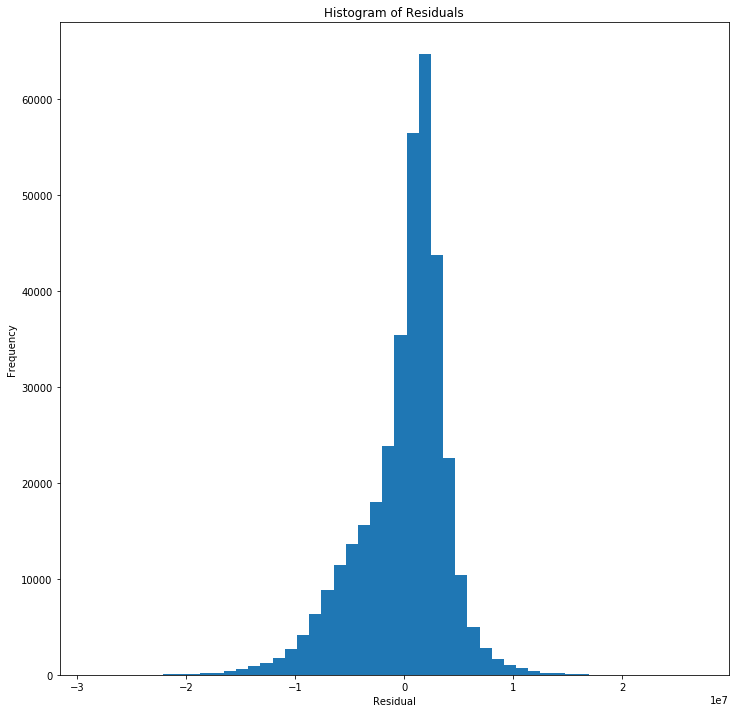

In [52]:
plt.subplots(figsize=(12,12))
plt.hist(m_ols_fs2.resid, bins=50)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [53]:
statsmodels.stats.diagnostic.normal_ad(m_ols_fs2.resid)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


(7420.5558233218035, 0.0)

- The Anderson-Darling Normality test has the null hypothesis that the data is normally distributed. The p-value of the test statistic is very small, thus we reject the null hypothesis that the data is normally distributed.

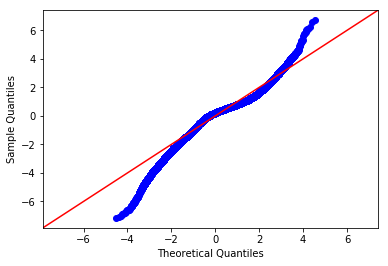

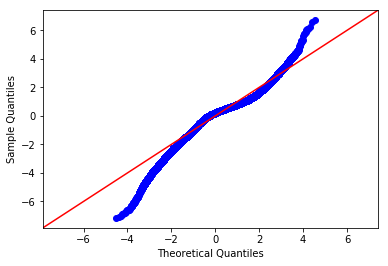

In [54]:
qqplot(m_ols_fs2.resid, line='45', fit=True)

- The Q-Q plot shows that the issues with the model are at the tails (low and high values). It also confirms the non-normally distributed residuals. 

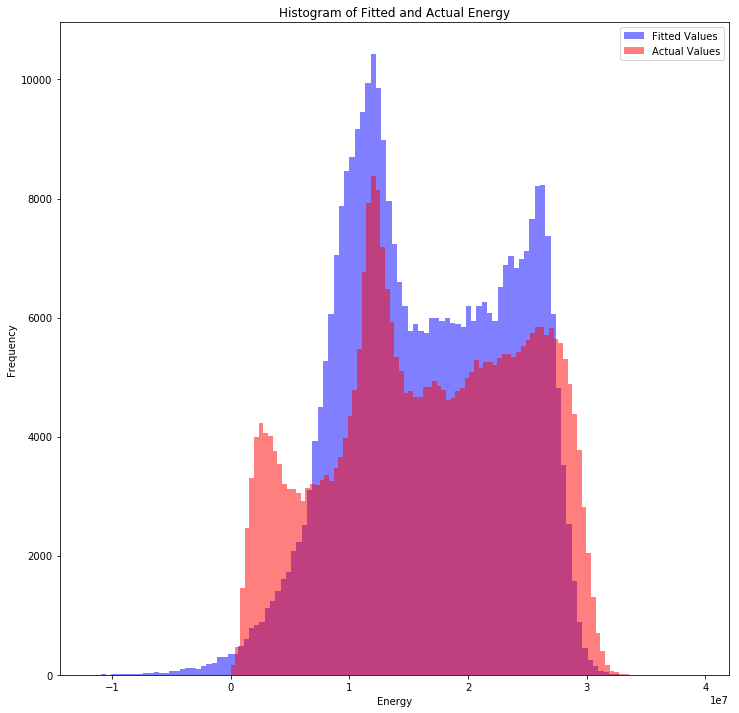

In [55]:
plt.subplots(figsize=(12,12))
plt.hist(m_ols_fs2.predict(X_train), bins=100, color='blue', alpha=0.5)
plt.hist(y_train, bins=100, color='red', alpha=0.5)
plt.title("Histogram of Fitted and Actual Energy")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend(['Fitted Values', 'Actual Values'])
plt.show()

## Conclusions

- No Multicollinearity between variables
- Residuals violate Homoscedasticity (constant variance).
- Residuals are non-normal.
- The model does have predictive power:
    - R2 = 0.749
    - Test data adj. R2 = 0.867
    - MAE on the scale of ~10-15% of average energy values

## Models 1a-c Conclusions

- Model 1a:
    - Average CV MAE: 2,353,201
    - Test MAE: 2,195,538
    - Train data R2: 0.833
    - Test data adj. R2: 0.915
- Model 1b:
    - Average CV MAE: 2,552,359
    - Test MAE: 2,359,393
    - Train data R2: 0.809
    - Test data adj. R2: 0.901
- Model 1c:
    - Average CV MAE: 3,021,995
    - Test MAE: 2,844,458
    - Train data R2: 0.749
    - Test data adj. R2: 0.867

- All three models broke the standard assumptions of a linear regression model:
    - Models 1a and 1b had multicollinearity in the features.
    - All models violated homoscedasticity (constant variance) of residuals.
    - All models had non-normal residuals.
- The conclusion here is that a linear regression is not the best type of model for this dataset. Even with drastically reduced features to eliminate multicollinearity, the models still predict unevenly. Additionally, as the features were reduced, average CV and test MAE increased, and R2 decreased. Lastly, the linear regressions predict negative values as an implicit artifact of the method.

# Model 2: Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is a process that can be used to optimize a linear regression. It works by minimizing a loss function by following a gradient.

In [80]:
X_train = df.loc['1994':'2003'].iloc[:, 1:].reset_index()
y_train = df.energy.loc['1994':'2003'].reset_index()
X_test = df.loc['2004':'2007'].iloc[:, 1:].reset_index()
y_test = df.energy.loc['2004':'2007'].reset_index()

## Hyperparameter tuning

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

years = list(range(1994, 2004))

train_indices = [0, 0, 0]
test_indices = [0, 0, 0]

train_indices[0] = X_train[(X_train.Date.dt.year != 1994) & (X_train.Date.dt.year != 1995) & (X_train.Date.dt.year != 1996)].index
train_indices[1] = X_train[(X_train.Date.dt.year != 1997) & (X_train.Date.dt.year != 1998) & (X_train.Date.dt.year != 1999)].index
train_indices[2] = X_train[(X_train.Date.dt.year != 2000) & (X_train.Date.dt.year != 2001) & (X_train.Date.dt.year != 2002) & (X_train.Date.dt.year != 2003)].index

test_indices[0] = y_train[(y_train.Date.dt.year == 1994) | (y_train.Date.dt.year == 1995) | (y_train.Date.dt.year == 1996)].index
test_indices[1] = y_train[(y_train.Date.dt.year == 1997) | (y_train.Date.dt.year == 1998) | (y_train.Date.dt.year == 1999)].index
test_indices[2] = y_train[(y_train.Date.dt.year == 2000) | (y_train.Date.dt.year == 2001) | (y_train.Date.dt.year == 2002) | (y_train.Date.dt.year == 2003)].index

custom_cv = zip(train_indices, test_indices)

n_samples = len(X_train[(X_train.Date.dt.year != 1994) & (X_train.Date.dt.year != 1995) & (X_train.Date.dt.year != 1996)].index)

guess_alpha = list(10.0**-np.arange(2,6))
guess_max_iter = np.ceil(10**6 / n_samples) * 10
guess_epsilon = 0.1

alpha_space = guess_alpha
max_iter_space = [guess_max_iter - 10, guess_max_iter, guess_max_iter + 10]
epsilon_space = [guess_epsilon*0.1, guess_epsilon, guess_epsilon*10]
loss_space = ['squared_loss', 'huber', 'epsilon_insensitive']

param_grid = {'m__alpha': alpha_space,
              'm__max_iter': max_iter_space,
              'm__epsilon':epsilon_space,
              'm__loss': loss_space}

pipeline = Pipeline([('scaler',StandardScaler()), ('m', SGDRegressor())])

reg_sgd_cv = GridSearchCV(pipeline, param_grid, cv=custom_cv, verbose=0, n_jobs=-1)
    
reg_sgd_cv.fit(X_train.iloc[:,1:], y_train.iloc[:,1:])
    
print("Tuned Gradient Boosting Parameters: {}".format(reg_sgd_cv.best_params_)) 
print("Best score is {}".format(reg_sgd_cv.best_score_))

In [ ]:
# Save the model
sgd_pickle = "sgd_pickle.pkl"
with open(sgd_pickle, 'wb') as file:
    pickle.dump(reg_sgd_cv, file)

In [84]:
# Load the model saved
with open("sgd_pickle.pkl", 'rb') as file:
    reg_sgd_cv = pickle.load(file)
    
    
print("Tuned Gradient Boosting Parameters: {}".format(reg_sgd_cv.best_params_)) 
print("Best score is {}".format(reg_sgd_cv.best_score_))

Tuned Gradient Boosting Parameters: {'m__alpha': 1e-05, 'm__epsilon': 0.1, 'm__loss': 'squared_loss', 'm__max_iter': 60.0}
Best score is 0.8290493279999691


In [85]:
pipeline = Pipeline([('scaler',StandardScaler()), ('m', SGDRegressor(alpha=0.00001, epsilon = 0.1, loss='squared_loss', max_iter=600))])

In [86]:
X_train = df.loc['1994':'2003'].iloc[:, 1:]
y_train = df.energy.loc['1994':'2003']
X_test = df.loc['2004':'2007'].iloc[:, 1:]
y_test = df.energy.loc['2004':'2007']

In [87]:
average_cv, cv_scores = cv_score(pipeline, X_train, y_train, score_func=mean_absolute_error)
print('Average CV MAE: %.0f' % average_cv)
cv_scores.reset_index(drop=True)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d

Average CV MAE: 2355460


fold        cv_mae
0     1  2.379890e+06
1     2  2.495121e+06
2     3  2.371375e+06
3     4  2.279861e+06
4     5  2.251055e+06

In [88]:
scaler = StandardScaler()
# Number of samples has changed so max_iter must increase
reg = SGDRegressor(alpha=0.00001, epsilon = 0.1, loss='squared_loss', max_iter=600)
pipeline = make_pipeline(scaler, reg)

pipeline.fit(X_train, y_train)
print('MAE: %.0f' % mean_absolute_error(pipeline.predict(X_test), y_test))

MAE: 2210467


In [89]:
pipeline.score(X_train, y_train)

0.8321894337153131

In [135]:
# Calculate test data Pearson R
model_2_test_pearson = pearsonr(pipeline.predict(X_test), y_test)
model_2_test_pearson_adj = 1 - (1 - model_2_test_pearson[0]) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
model_2_test_pearson_adj

0.9141644809475926

## 2 SGD Model Evaluation

### Homoscedasticity (constant variance) of residuals

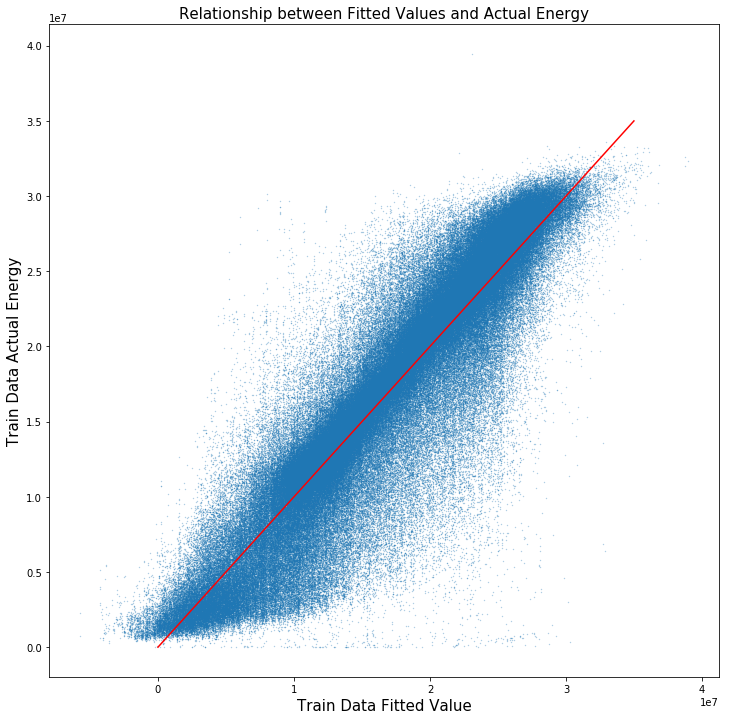

In [91]:
plt.subplots(figsize=(12, 12))
plt.scatter(pipeline.predict(X_train), y_train, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Train Data Fitted Value", fontsize=15)
plt.ylabel("Train Data Actual Energy", fontsize=15)
plt.title("Relationship between Fitted Values and Actual Energy", fontsize=15)
plt.show()

-  Using visual inspection, we can see that the residuals do not exhibit constant variance. Lower energy values are underestimated and higher energy values are overestimated. 

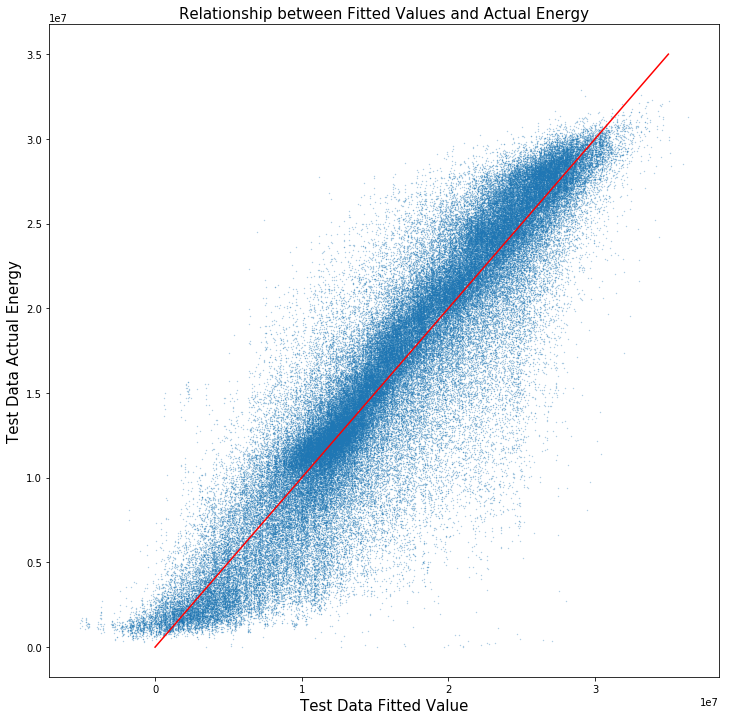

In [92]:
plt.subplots(figsize=(12, 12))
plt.scatter(pipeline.predict(X_test), y_test, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Energy", fontsize=15)
plt.title("Relationship between Fitted Values and Actual Energy", fontsize=15)
plt.show()

In [93]:
residuals = pipeline.predict(X_train) - y_train
_, _, f_value, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(residuals, X_train)

In [94]:
print('bp test f_value: ' + str(f_value))
print('bp test f_pvalue: ' + str(f_pvalue))

bp test f_value: 1212.0914333428777
bp test f_pvalue: 0.0


- the very low p-value indicates a very likely violation of homoscedasticity (constant variance)

### Normally distributed residuals

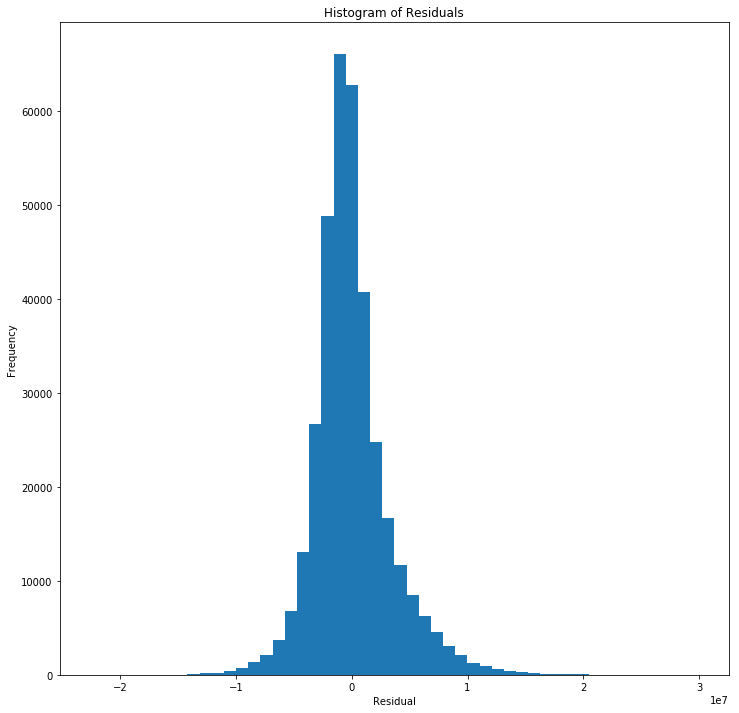

In [95]:
plt.subplots(figsize=(12,12))
plt.hist(residuals, bins=50)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [98]:
statsmodels.stats.diagnostic.normal_ad(residuals)

(inf, 0.0)

- The Anderson-Darling Normality test has the null hypothesis that the data is normally distributed. The p-value of the test statistic is very small, thus we reject the null hypothesis that the data is normally distributed.

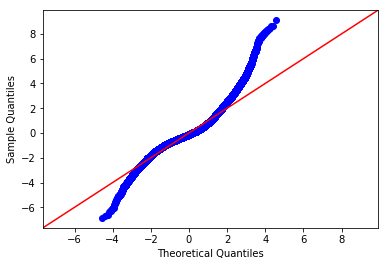

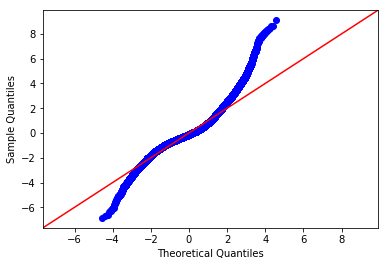

In [97]:
qqplot(residuals, line='45', fit=True)

- The Q-Q plot shows that the issues with the model are at the tails (low and high values). It also confirms the non-normally distributed residuals. 

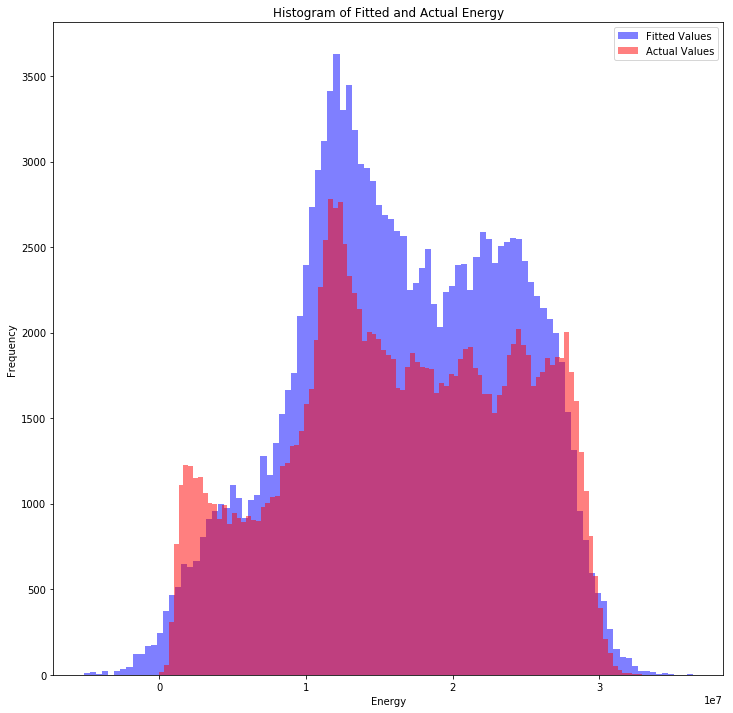

In [99]:
plt.subplots(figsize=(12,12))
plt.hist(pipeline.predict(X_test), bins=100, color='blue', alpha=0.5)
plt.hist(y_test, bins=100, color='red', alpha=0.5)
plt.title("Histogram of Fitted and Actual Energy")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend(['Fitted Values', 'Actual Values'])
plt.show()

## Conclusions

- Residuals violate Homoscedasticity (constant variance).
- Residuals are non-normal.
- The model does have predictive power:
    - R2 = 0.833
    - Average CV MAE = 2,360,498
    - Test MAE = 2,204,851, on the scale of ~10-15% of average energy values

- The model performs very similarily to the simple OLS with no feature selection. Because the basis of the model is still linear regression, it is unsurprising that there are issues with the prediction made evident by the form of the residuals.

# Model: GRADIENT BOOSTING REGRESSOR
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

Gradient Boosting Regression is an ensemble prediction process. Ensemble methods, which use a collection of predictors to give a final prediction, are used to reduce noise, variance, and bias. As the name implies, GBR uses boosting i.e. the ensemble of predictors are made sequentially. The logic, is that the subsequent predictors 'learn' from the errors of the previous predictors - observations with higher errors from previous predictors are more likely to appear in subsequent predictors.

GBR in sklearn uses an ensemble of decision tree regressors. The loss function we will be using is 'lad', the least absolute deviation, is it is in line with our cv score function, mean absolute error. 

In [100]:
X_train = df.loc['1994':'2003'].iloc[:, 1:].reset_index()
y_train = df.energy.loc['1994':'2003'].reset_index()
X_test = df.loc['2004':'2007'].iloc[:, 1:].reset_index()
y_test = df.energy.loc['2004':'2007'].reset_index()

## Hyperparameter tuning - Run on AWS

In [ ]:
'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

years = list(range(1994, 2004))

train_indices = [0, 0, 0]
test_indices = [0, 0, 0]

train_indices[0] = X_train[(X_train.Date.dt.year != 1994) & (X_train.Date.dt.year != 1995) & (X_train.Date.dt.year != 1996)].index
train_indices[1] = X_train[(X_train.Date.dt.year != 1997) & (X_train.Date.dt.year != 1998) & (X_train.Date.dt.year != 1999)].index
train_indices[2] = X_train[(X_train.Date.dt.year != 2000) & (X_train.Date.dt.year != 2001) & (X_train.Date.dt.year != 2002) & (X_train.Date.dt.year != 2003)].index

test_indices[0] = y_train[(y_train.Date.dt.year == 1994) | (y_train.Date.dt.year == 1995) | (y_train.Date.dt.year == 1996)].index
test_indices[1] = y_train[(y_train.Date.dt.year == 1997) | (y_train.Date.dt.year == 1998) | (y_train.Date.dt.year == 1999)].index
test_indices[2] = y_train[(y_train.Date.dt.year == 2000) | (y_train.Date.dt.year == 2001) | (y_train.Date.dt.year == 2002) | (y_train.Date.dt.year == 2003)].index

custom_cv = zip(train_indices, test_indices)

n_estimators_space = [1000, 1500, 2000]
max_features_space = [8, 10, 12]
max_depth_space = [6, 7, 8]

param_grid = {'n_estimators': n_estimators_space, 'max_features': max_features_space, 'max_depth':max_depth_space}

reg = GradientBoostingRegressor(loss='lad', subsample=0.5)
reg_cv = GridSearchCV(reg, param_grid, cv=custom_cv, verbose=50, n_jobs=-1)
    
reg_cv.fit(X_train.iloc[:,1:], y_train.iloc[:,1:].values.ravel())
    
print("Tuned Gradient Boosting Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(reg_cv.best_score_))
'''

In [ ]:
'''
gbr_pickle = "gbr_pickle.pkl"
with open(gbr_pickle, 'wb') as file:
    pickle.dump(reg_cv, file)
'''

In [101]:
# Load the model saved from AWS
with open("gbr_pickle.pkl", 'rb') as file:
    reg_cv = pickle.load(file)

In [102]:
reg_cv.best_params_

{'max_depth': 6, 'max_features': 10, 'n_estimators': 1000}

In [104]:
X_train = df.loc['1994':'2003'].iloc[:, 1:]
y_train = df.energy.loc['1994':'2003']
X_test = df.loc['2004':'2007'].iloc[:, 1:]
y_test = df.energy.loc['2004':'2007']

In [105]:
reg = GradientBoostingRegressor(loss='lad', n_estimators=1000, max_features=10, max_depth=6, subsample=0.5, verbose=0)

average_cv, cv_scores = cv_score(reg, X_train, y_train, score_func=mean_absolute_error)
print('Average CV MAE: %.0f' % average_cv)
cv_scores.reset_index(drop=True)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWar

Average CV MAE: 2120044


fold        cv_mae
0     1  2.145426e+06
1     2  2.242936e+06
2     3  2.069729e+06
3     4  2.051547e+06
4     5  2.090580e+06

In [106]:
reg_gbr = GradientBoostingRegressor(loss='lad', n_estimators=1000, max_features=10, max_depth=6, subsample=0.5, verbose=1)
reg_gbr.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1     6342996.3084      541135.7374           15.72m
         2     5838332.5710      505058.7215           15.84m
         3     5407192.7358      439033.5750           16.50m
         4     5019062.1368      388261.6288           16.36m
         5     4673994.9613      339074.9007           17.25m
         6     4348728.3695      320793.1338           17.81m
         7     4082364.3458      264713.5343           18.38m
         8     3839622.2756      250418.0022           19.08m
         9     3608752.8918      224520.0741           18.94m
        10     3424009.8889      185165.7868           18.94m
        20     2448019.5531       50517.8849           20.98m
        30     2181811.9687       13719.7753           19.13m
        40     2098439.0302        4959.0274           18.02m
        50     2065490.7097        1747.5054           17.65m
        60     2036753.8316        1440.8252           17.67m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=6,
                          max_features=10, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [113]:
mae = mean_absolute_error(reg_gbr.predict(X_test), y_test)
score = reg_gbr.score(X_test, y_test)

In [114]:
mae

1971083.1407718393

In [115]:
score

0.8467145886856162

In [116]:
model_gbr_mae = 1975215
mean_energy = df.energy.mean()

mae_pct = model_gbr_mae / mean_energy * 100
mae_pct

11.921893543121802

In [120]:
# Calculate test data Pearson R
model_3_test_pearson = pearsonr(reg_gbr.predict(X_test), y_test)
model_3_test_pearson_adj = 1 - (1 - model_3_test_pearson[0]) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
model_3_test_pearson_adj

0.9235273046244552

## 3 GBR Model Evaluation

### Homoscedasticity (constant variance) of residuals

In [122]:
X_train = df.loc['1994':'2003'].iloc[:, 1:]
y_train = df.energy.loc['1994':'2003']
X_test = df.loc['2004':'2007'].iloc[:, 1:]
y_test = df.energy.loc['2004':'2007']

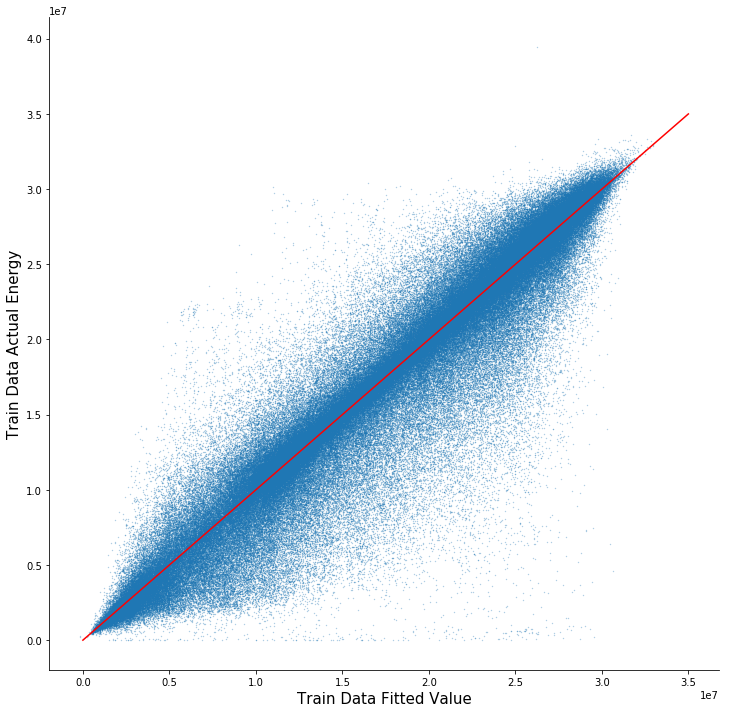

In [123]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(reg_gbr.predict(X_train), y_train, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Train Data Fitted Value", fontsize=15)
plt.ylabel("Train Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.show()

-  Using visual inspection, we can see that the residuals do not exhibit constant variance. Lower energy values are overestimated consistently.

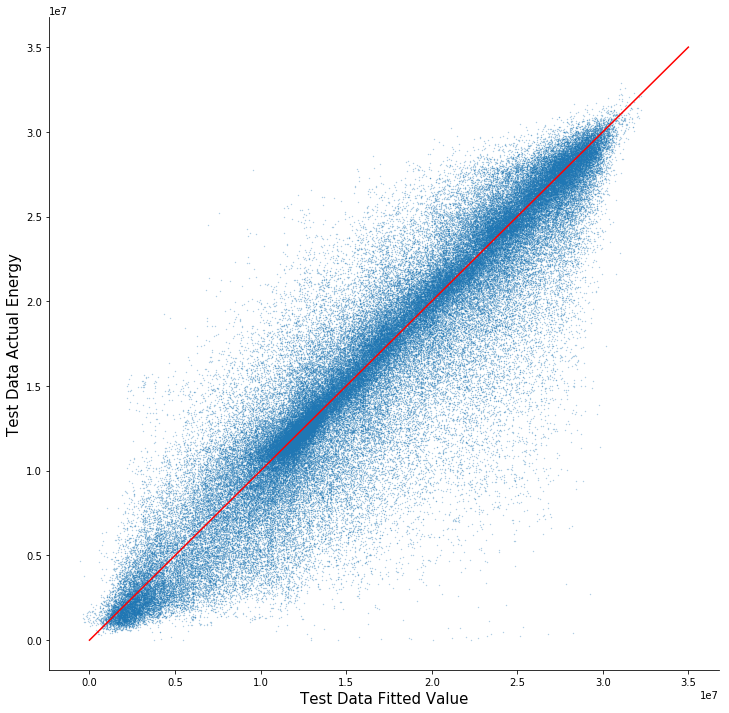

In [124]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(reg_gbr.predict(X_test), y_test, s=0.1, alpha=0.5)
plt.plot([0,35000000], [0,35000000], '-', c='red')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Energy", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.show()

In [125]:
residuals = reg_gbr.predict(X_train) - y_train
_, _, f_value, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(residuals, X_train)

In [126]:
print('bp test f_value: ' + str(f_value))
print('bp test f_pvalue: ' + str(f_pvalue))

bp test f_value: 638.9931494353623
bp test f_pvalue: 0.0


- the very low p-value indicates a very likely violation of homoscedasticity (constant variance)

### Normally distributed residuals

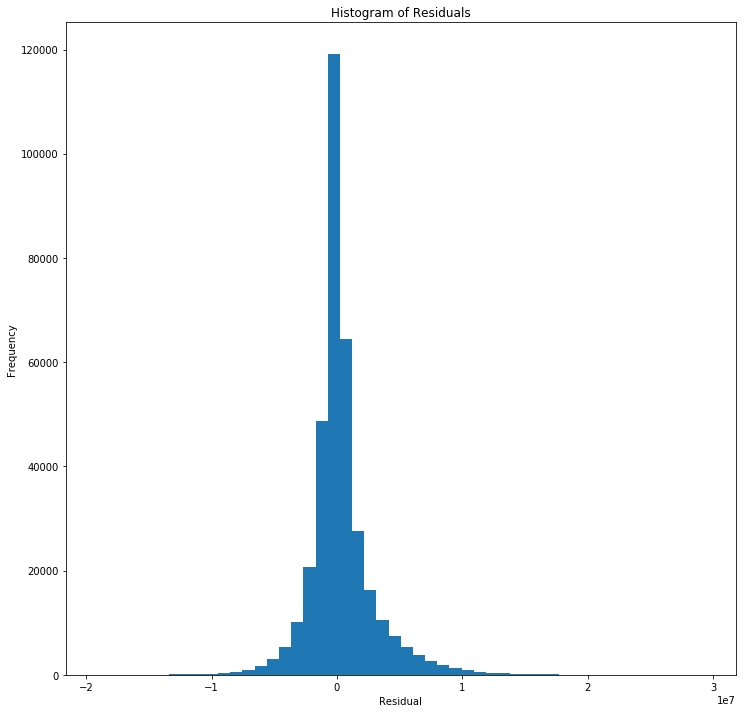

In [127]:
plt.subplots(figsize=(12,12))
plt.hist(residuals, bins=50)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [128]:
statsmodels.stats.diagnostic.normal_ad(residuals.values)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\statsmodels\stats\_adnorm.py:66: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


(inf, 0.0)

- The Anderson-Darling Normality test has the null hypothesis that the data is normally distributed. The p-value of the test statistic is very small, thus we reject the null hypothesis that the data is normally distributed.

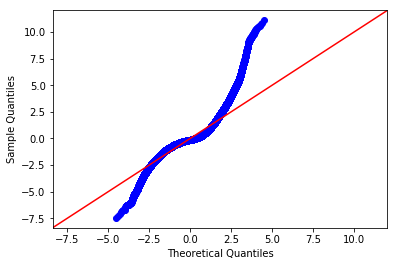

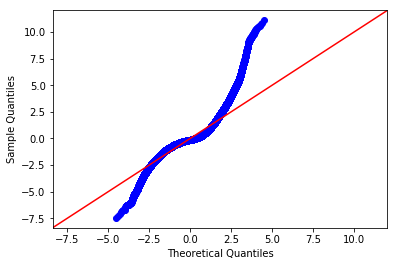

In [129]:
qqplot(residuals, line='45', fit=True)

- The Q-Q plot shows that the issues with the model are at the tails (low and high values). It also confirms the non-normally distributed residuals. 

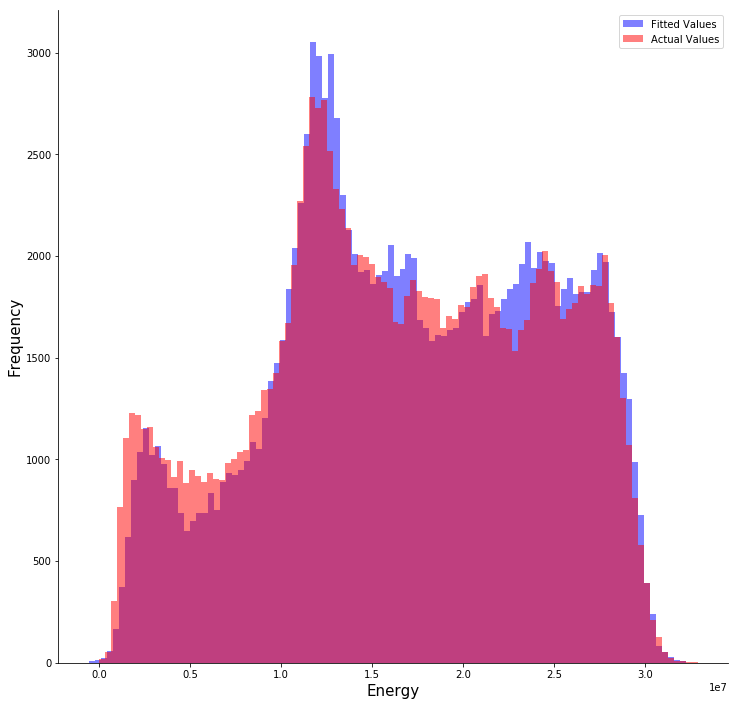

In [130]:
fig, ax = plt.subplots(figsize=(12,12))
plt.hist(reg_gbr.predict(X_test), bins=100, color='blue', alpha=0.5)
plt.hist(y_test, bins=100, color='red', alpha=0.5)

plt.xlabel("Energy", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(['Fitted Values', 'Actual Values'])

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.show()

## Conclusions

- Residuals violate Homoscedasticity (constant variance).
- Residuals are non-normal.
- The model does have predictive power:
    - R2 = 0.846
    - Average CV MAE = 2,123,177
    - Test MAE = 1,975,215, on the scale of ~10-15% of average energy values

- The model performs better than all other models. 